# Elaboration du Notre Modèle de Prediction

Nous voila enfin arrivé à la phase finale de notre projet , cele consistant à la creation et à l'evaluation de notre modèle.
Au sein de cette partie nous allons effectuer les taches suivantes:
- Data Sampling : consistera à subdiviser notre ensemblle d'apprentissage en une partie pour l'entrainement du modèle :(training set) et une autre pour le test et evaluation du modèle :(test set) nous utiliserons les techniques d'echantillonage de la librairie scikit-learn
- Feature Encoding : Vue que la plus part des algorithmes du machine learning ne fonctionnent qu'avec des données de nature numeriques , toutes nos variables seront encodées en variables binaires en utilisant la technique du one-hot encoding
- Shortlist - Pomissing models: Dans cette partie nous allons entrainer differents algorithmes du Machin Learning pour predire notre output à la fin nous ne  retiendrons que les modèles les plus prometteur après leur evaluation
- Enfin Nous allons optimiser les modèles et ne retenir que les modèles les plus prommeteur.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #for beatiful visualizations
%matplotlib inline 
import scipy.stats as scs #for statistics
import operator
from scipy.stats import chi2_contingency
import matplotlib.ticker as ticker
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import *

In [2]:
Techo=pd.read_csv("../dataset/DatasetTechno.csv",index_col="Unnamed: 0")
Medecine=pd.read_csv("../dataset/DatasetMedecine.csv",index_col="Unnamed: 0")
Economie=pd.read_csv("../dataset/DatasetEconomie.csv",index_col="Unnamed: 0")
dataset=pd.read_csv("../dataset/DatasetFinalV1.csv",index_col="Unnamed: 0")

In [30]:
sample=dataset.loc[dataset.FAC=='FM'].head(3).append( dataset.loc[dataset.FAC=='FSTA'].head(5).append(dataset.loc[dataset.FAC=='FSEG'].head(5))).append(dataset.loc[dataset.FAC=='FD'].head(3)).append(dataset.loc[dataset.FAC=='FT'].head(2)).append(dataset.loc[dataset.FAC=='FPSE'].head(4)).append(dataset.loc[dataset.FAC=='FSDC'].head(3))

In [37]:
sample[['ID','DIPPERC','AGE','GENDER','FAC','CGPA']].head(2)

,ID,DIPPERC,AGE,GENDER,FAC,CGPA
55,10384,59.0,22,F,FM,59.15
71,11610,52.0,23,H,FM,44.00


Commencons par la préparation des nos données pour les algorithmes

## Preparation des données pour les algorithmes 

Au sein de cette partie nous allons écrire des fonctions qui effectuerons la préparartion automatiques des nos données avant l'execution des algorithmes '

La premiere transformation que nous fairons sera l'encodage de nos données et pour celle ci nous allons utiliser la technique appelé one-hot encoding

Mais avant supprimons les colones qui n'ont aucun interet dans notre ensemble d'apprentissage.

Commencons par supprimer les colonnes sexe, age , pourcentage à l'exetat qui comme souligné au paragraphe précedant n'ont aucune influence sur notre variable finale

In [38]:
dataset.columns

Index([u'ID', u'SCHOOLSTATUS', u'SCHOOL_RIGHT', u'OPTION_RIGHT', u'FAC',
       u'SCHOOLPROVINCE', u'GENDER', u'DIPPERC', u'AGE', u'CGPA',
       u'DistinctionRatio', u'EchecRatio', u'NACADYEAR',
       u'Pass1stSessionRatio'],
      dtype='object')

In [3]:
dataset.head(1)

,ID,SCHOOLSTATUS,SCHOOL_RIGHT,OPTION_RIGHT,FAC,SCHOOLPROVINCE,GENDER,DIPPERC,AGE,CGPA,DistinctionRatio,EchecRatio,NACADYEAR,Pass1stSessionRatio
0,3895,protestant,zanner,commmerciale et adm,FSEG,NORD-KIVU,H,52.0,31,59.400002,G,G,1.0,G


In [4]:
dataset.set_index(keys='ID',inplace=True)

now let get only the data with the CGPA after

Avant de continuer verifions les correlations existantes entre les colonnes SCHOOL,SCHOOLSTATUS, et SCHOOLPROVINCE

In [29]:
# %load ChiSquareCal.py
class ChiSquareCalc(object):
    """this class is designed to calculated and interpret the relationship between 2 categorials variables by computing the chi square test between them
    you can find more on chi square test on this video https://www.youtube.com/watch?v=misMgRRV3jQ
    it will use pandas , numpy ,searborn matplotlib , scipy
    """
    def __init__(self, X,Y,dataset,**kwargs):
        """we will initailise the with 2 colums of a datafrme the input must be a data and columns names"""
        if isinstance(dataset,pd.DataFrame) and isinstance(X,str)and isinstance(Y,str) and X in dataset.columns and Y in dataset.columns :
            if operator.and_(operator.__eq__(dataset[X].dtypes, 'object'),operator.__eq__(dataset[Y].dtypes, 'object')):
                self.dataset=dataset
                self.X=dataset[X]
                self.Y=dataset[Y]
                self.contingency=pd.DataFrame()
                self.c=0
                self.p=0
                self.dof=0
                self.q=0.95 #lower tail probability
                self.criticalValue=0
            else:
                raise TypeError('Class only deal wih categorial columns')
        else:
            raise TypeError('Columns names must be string and data must be a DataFrame')
    def contengencyTable(self):
        """this method will return a contengency table of the 2 variables"""
        self.contingency = pd.crosstab(self.X,self.Y)
        return self.contingency
    def chisquare(self):
        """this one will calculate the chi square value and return
        q: chi square results
        df: degree of freedom
        p: probability
        expexcted: excepected frequency table
        """
        if (not self.contingency.empty):
            self.c, self.p, self.dof, expected = chi2_contingency(self.contingency)
            return pd.DataFrame(expected,columns=self.contingency.columns,index=self.contingency.index)
        else:
            raise ValueError('contingency table must be initialised')
    def conclude(self,on):
        """
        we can decide to conclude on chi square value(chi) or on p (p)value
        Here is how we build the conclusion according to p value
         Probability of 0: It indicates that both categorical variable are dependent
         Probability of 1: It shows that both variables are independent.
         Probability less than 0.05: It indicates that the relationship between the variables is significant at 95% confidence
        And according to chi square value and df we use a ccritical value calculate with :
        q:lower tail probability
        df:degree of freedom
         the conclusion is approving or rejecting a null hypothesis
        """
        NulHyp='is no relationship between '+self.X+'and '+self.Y
        self.criticalValue=scs.chi2.ppf(q = self.q, df =self.dof)
        if on not in ['chi','p']:
            raise ValueError('choose chi or p')
        else:
            if on=='chi':
                if self.criticalValue > self.c:
                    return 'Accepted : '+NulHyp
                else:
                    return 'null hypothesis is rejected : There is a relationhip between the categorical variable'
            else:
                if self.p==0:
                    return ' It indicates that both categorical variable are dependent'
                elif self.p==1:
                    return 'It shows that both variables are independent'
                elif self.p <(1-self.q):
                    return 'It indicates that the relationship between the variables is significant at confidence of %s',self.q
                else:
                    return 'there is no relationship '
    def DrawPlot(self,**kwargs):
        """ and as for bonus you can draw plot to visualise the relationship """
        plt.figure(figsize= kwargs.get('size'))
        plt.title('Distribution de ' )
        plt.xlabel('Label')
        ax=sns.countplot(hue=self.X,y=self.Y,data=self.dataset,orient=kwargs.get('orient'))
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        return ax
        



In [11]:
SchoolStat=ChiSquareCalc(dataset=datasetCGPA,X='SCHOOL_RIGHT',Y='SCHOOLSTATUS')

In [12]:
SchoolStat.contengencyTable()

SCHOOLSTATUS,autodidacte,catholique,inconnu,kimbanguiste,musulman,privé,protestant,publique
SCHOOL_RIGHT,,,,,,,,
1uto,0,0,1,0,0,0,0,0
53,0,0,1,0,0,0,0,0
54,0,0,1,0,0,0,0,0
61,0,0,2,0,0,0,0,0
Alleluya,0,0,2,0,0,0,0,0
BWANGA,0,0,2,0,0,0,0,0
Bungulu Beni,0,0,1,0,0,0,0,0
GRACIA,0,0,1,0,0,0,0,0
I DE BKV,0,0,1,0,0,0,0,0


In [13]:
SchoolStat.chisquare()

SCHOOLSTATUS,autodidacte,catholique,inconnu,kimbanguiste,musulman,privé,protestant,publique
SCHOOL_RIGHT,,,,,,,,
1uto,0.009332,0.276988,0.146554,0.001060,0.008059,0.113680,0.290562,0.153765
53,0.009332,0.276988,0.146554,0.001060,0.008059,0.113680,0.290562,0.153765
54,0.009332,0.276988,0.146554,0.001060,0.008059,0.113680,0.290562,0.153765
61,0.018664,0.553977,0.293107,0.002121,0.016119,0.227359,0.581124,0.307529
Alleluya,0.018664,0.553977,0.293107,0.002121,0.016119,0.227359,0.581124,0.307529
BWANGA,0.018664,0.553977,0.293107,0.002121,0.016119,0.227359,0.581124,0.307529
Bungulu Beni,0.009332,0.276988,0.146554,0.001060,0.008059,0.113680,0.290562,0.153765
GRACIA,0.009332,0.276988,0.146554,0.001060,0.008059,0.113680,0.290562,0.153765
I DE BKV,0.009332,0.276988,0.146554,0.001060,0.008059,0.113680,0.290562,0.153765


In [19]:
SchoolStat.conclude(on='chi')

0       null hypothesis is rejected : is no relationsh...
1       null hypothesis is rejected : is no relationsh...
2       null hypothesis is rejected : is no relationsh...
3       null hypothesis is rejected : is no relationsh...
4       null hypothesis is rejected : is no relationsh...
5       null hypothesis is rejected : is no relationsh...
6       null hypothesis is rejected : is no relationsh...
7       null hypothesis is rejected : is no relationsh...
8       null hypothesis is rejected : is no relationsh...
9       null hypothesis is rejected : is no relationsh...
10      null hypothesis is rejected : is no relationsh...
11      null hypothesis is rejected : is no relationsh...
12      null hypothesis is rejected : is no relationsh...
13      null hypothesis is rejected : is no relationsh...
14      null hypothesis is rejected : is no relationsh...
15      null hypothesis is rejected : is no relationsh...
16      null hypothesis is rejected : is no relationsh...
17      null h

In [18]:
SchoolStat.dof

4130

In [20]:
SchoolStat.p

0.0

Comme notre hypothese null es rejeter nous pouvons affirmativement conclure qu'il existe une relation entre l'ecole et le status de l'ecole'

DOnc connaissance l'ecole  nous pouvons savaoir le status

In [22]:
SchoolStat2=ChiSquareCalc(dataset=datasetCGPA,X='SCHOOL_RIGHT',Y='SCHOOLPROVINCE')

In [23]:
SchoolStat2.contengencyTable()

SCHOOLPROVINCE,BANDUNDU,BAS CONGO,EQUATEUR,K OR,KASAI OCCIDENTAL,KASAI ORIENTAL,KATANGA,KIGALI,KINSHASA,MANIEMA,NORD-KIVU,NYARUKENGE,ORIENTALE,OUEST,SUD-KIVU,inconnu
SCHOOL_RIGHT,,,,,,,,,,,,,,,,
1uto,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
53,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
54,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
61,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0
Alleluya,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0
BWANGA,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0
Bungulu Beni,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
GRACIA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
I DE BKV,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [26]:
SchoolStat2.chisquare()

SCHOOLPROVINCE,BANDUNDU,BAS CONGO,EQUATEUR,K OR,KASAI OCCIDENTAL,KASAI ORIENTAL,KATANGA,KIGALI,KINSHASA,MANIEMA,NORD-KIVU,NYARUKENGE,ORIENTALE,OUEST,SUD-KIVU,inconnu
SCHOOL_RIGHT,,,,,,,,,,,,,,,,
1uto,0.002545,0.000424,0.000848,0.000212,0.000636,0.002121,0.005090,0.000424,0.014846,0.008696,0.784730,0.000212,0.017603,0.000424,0.156098,0.005090
53,0.002545,0.000424,0.000848,0.000212,0.000636,0.002121,0.005090,0.000424,0.014846,0.008696,0.784730,0.000212,0.017603,0.000424,0.156098,0.005090
54,0.002545,0.000424,0.000848,0.000212,0.000636,0.002121,0.005090,0.000424,0.014846,0.008696,0.784730,0.000212,0.017603,0.000424,0.156098,0.005090
61,0.005090,0.000848,0.001697,0.000424,0.001273,0.004242,0.010180,0.000848,0.029692,0.017391,1.569459,0.000424,0.035207,0.000848,0.312195,0.010180
Alleluya,0.005090,0.000848,0.001697,0.000424,0.001273,0.004242,0.010180,0.000848,0.029692,0.017391,1.569459,0.000424,0.035207,0.000848,0.312195,0.010180
BWANGA,0.005090,0.000848,0.001697,0.000424,0.001273,0.004242,0.010180,0.000848,0.029692,0.017391,1.569459,0.000424,0.035207,0.000848,0.312195,0.010180
Bungulu Beni,0.002545,0.000424,0.000848,0.000212,0.000636,0.002121,0.005090,0.000424,0.014846,0.008696,0.784730,0.000212,0.017603,0.000424,0.156098,0.005090
GRACIA,0.002545,0.000424,0.000848,0.000212,0.000636,0.002121,0.005090,0.000424,0.014846,0.008696,0.784730,0.000212,0.017603,0.000424,0.156098,0.005090
I DE BKV,0.002545,0.000424,0.000848,0.000212,0.000636,0.002121,0.005090,0.000424,0.014846,0.008696,0.784730,0.000212,0.017603,0.000424,0.156098,0.005090


In [27]:
SchoolStat2.conclude(on='p')

' It indicates that both categorical variable are dependent'

In [28]:
SchoolStat2.conclude(on='chi')

0       null hypothesis is rejected : is no relationsh...
1       null hypothesis is rejected : is no relationsh...
2       null hypothesis is rejected : is no relationsh...
3       null hypothesis is rejected : is no relationsh...
4       null hypothesis is rejected : is no relationsh...
5       null hypothesis is rejected : is no relationsh...
6       null hypothesis is rejected : is no relationsh...
7       null hypothesis is rejected : is no relationsh...
8       null hypothesis is rejected : is no relationsh...
9       null hypothesis is rejected : is no relationsh...
10      null hypothesis is rejected : is no relationsh...
11      null hypothesis is rejected : is no relationsh...
12      null hypothesis is rejected : is no relationsh...
13      null hypothesis is rejected : is no relationsh...
14      null hypothesis is rejected : is no relationsh...
15      null hypothesis is rejected : is no relationsh...
16      null hypothesis is rejected : is no relationsh...
17      null h

In [30]:
SchoolStat2.dof

8850

In [6]:
dataset.columns

Index([u'SCHOOLSTATUS', u'SCHOOL_RIGHT', u'OPTION_RIGHT', u'FAC',
       u'SCHOOLPROVINCE', u'GENDER', u'DIPPERC', u'AGE', u'CGPA',
       u'DistinctionRatio', u'EchecRatio', u'NACADYEAR',
       u'Pass1stSessionRatio'],
      dtype='object')

In [5]:
datasetCGPA=dataset[['DIPPERC', u'SCHOOL_RIGHT', u'OPTION_RIGHT', u'FAC' , u'CGPA','DistinctionRatio','EchecRatio','Pass1stSessionRatio']]

Dans une premiere approche nous allons utiliser le dataset CGPA pour la construction de notre modèle car ils ne contiendra uniquement que 3 attribues et reste seront utiliser ulterieurment

Nous allons construire notre ensemble d'apprentissage uniquement sur base de ces attribues  , les autres on été supprimées car ils ne disposent d'aucune corrlation avec le CGPA

In [5]:
datasetCGPA.head(5)

,DIPPERC,SCHOOL_RIGHT,OPTION_RIGHT,FAC,CGPA,DistinctionRatio,EchecRatio,Pass1stSessionRatio
ID,,,,,,,,
3895,52.0,zanner,commmerciale et adm,FSEG,59.400002,G,G,G
4048,53.0,zanner,commmerciale et adm,FSEG,40.000000,G,A,G
4217,54.0,zanner,commmerciale et adm,FSEG,61.299999,G,G,A
4347,53.0,zanner,commmerciale et adm,FSEG,60.599998,G,G,G
4409,58.0,zanner,commmerciale et adm,FSEG,48.599998,G,A,G


Avant de passer a l'encodage nous allons remplacer certaines écoles moins representé par un et un seul unique groupe  appéle autres école

In [60]:
len(datasetCGPA.SCHOOL_RIGHT.value_counts())

591

Nous pouvons aisement remarquer que nos étudiant proviennent de plus pret de 600 écoles differentes , nous allons essayer de reduire ces ecoles en essayans de prendre les écoles qui ont un maximum de 6 éleves à la fa

In [67]:
len(datasetCGPA.SCHOOL_RIGHT.value_counts()[datasetCGPA.SCHOOL_RIGHT.value_counts()>5])

133

Nous pouvons voir que la solution comme suggere ici https://datascience.stackexchange.com/a/9447/30464 nous allons utilser 
    la technique du one hot encoding suivie par celle de PCA Principal Component analysis pour les attribues comme la valeur de l'ecole de provenance qui dispose de plus de 596 differents valeurs'

https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues

In [ ]:
datasetCGPA.to_csv('../dataset/DatasetCGPA.csv')
datasetFin.to_csv('DatasetFinalV1.csv')
Techno.to_csv("DatasetTechno.csv")
Medecine.to_csv('DatasetMedecine.csv')
Economie.to_csv('DatasetEconomie.csv')
Droit.to_csv('DatasetDroit.csv')
Sante.to_csv('DatsetSante.csv')
Psyco.to_csv('DatasetPsycho.csv')
Teologie.to_csv('DatasetTeo.csv')

Commencons par proceder à l'encodage des toutes nos  variables categorielle en utilisant notre techique du one hot encoding

In [6]:
enc= LabelBinarizer()
X_train_1=datasetCGPA[[u'SCHOOLSTATUS', u'SCHOOL_RIGHT', u'OPTION_RIGHT',u'SCHOOLPROVINCE']]
X=datasetCGPA[['FAC','CGPA']]
catCol=X_train_1.columns
for col in catCol:
    # creating an exhaustive list of all possible categorical values
    
    data=dataset[[col]]
    enc.fit(data)
    # Fitting One Hot Encoding on train data
    temp = enc.transform(dataset[[col]])
    # Changing the encoded features into a data frame with new column names
    temp=pd.DataFrame(temp,columns=[ col + '-' +i for i in data[col].value_counts().index])
    # In side by side concatenation index values should be same
    # Setting the index values similar to the X_train data frame
    temp=temp.set_index(dataset.index)
    # adding the new One Hot Encoded varibales to the train data frame
    X=pd.merge(temp,X,right_index=True,left_index=True)

In [7]:
len(dataset.SCHOOL_RIGHT.value_counts()) + len(dataset.OPTION_RIGHT.value_counts()) +len(dataset.SCHOOLSTATUS.value_counts())  +  len(dataset.SCHOOLPROVINCE.value_counts())

645

In [21]:
X.columns

Index([u'SCHOOLPROVINCE-NORD-KIVU', u'SCHOOLPROVINCE-SUD-KIVU',
       u'SCHOOLPROVINCE-ORIENTALE', u'SCHOOLPROVINCE-KINSHASA',
       u'SCHOOLPROVINCE-MANIEMA', u'SCHOOLPROVINCE-inconnu',
       u'SCHOOLPROVINCE-KATANGA', u'SCHOOLPROVINCE-BANDUNDU',
       u'SCHOOLPROVINCE-KASAI ORIENTAL', u'SCHOOLPROVINCE-EQUATEUR',
       ...
       u'SCHOOLSTATUS-protestant', u'SCHOOLSTATUS-catholique',
       u'SCHOOLSTATUS-publique', u'SCHOOLSTATUS-inconnu',
       u'SCHOOLSTATUS-privé', u'SCHOOLSTATUS-autodidacte',
       u'SCHOOLSTATUS-musulman', u'SCHOOLSTATUS-kimbanguiste', u'FAC',
       u'CGPA'],
      dtype='object', length=647)

Après notre encodage nous pouvons aisement remarquer que notre ensemble d'apprentissage vient de passer de (4715, 4 )à (4715 , 647) et nous pouvons constater qu'on vient de l'elargir et ça risque de nous pauser un problème de performences lors de l'execution des algorithmes sur le training set!
Nous allons proceder ainsi pour le reste de du travail:
- Entrainer les algoritmes au sein de chaque faculté  et evaluer grace à une validation croisée
- Ensuite pour l'algorithme SVM nous allons proceder à une reduction des dimensions ensuite comparer les performances des algorithmes avant et après l'evaluation du modèle

Comme pour les chapitres précedants nous entrainerons et evaluerons nos modèles facultés par faculté enfin et enfin prédire le maximun de notre variable CGPA au sein de chaque faculté 

Nous pouvons aussi echelonner notre variable final le cGPA en le divisant par 100

In [24]:
X.loc[:,'CGPA']=X.CGPA/100

##### 1. Faculté de Medecine

Pour commencer notre entrainement nous alons echantilloner nos donnes pour constituter un ensemble d'apprentissahe (Training set), et un ensemble d'evaluation du modèle (test set)

In [6]:
Medecine=datasetCGPA.loc[datasetCGPA.FAC=='FM']

Nous allons avant tous standariser le poucentage pour un bon calcul nous allons le diviser par 100

In [37]:
Medecine.loc[:,'DIPPERC']=Medecine.DIPPERC/100

/Users/espyMur/Desktop/Memory-WorkingDir/memoryVenv/lib/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [38]:
Medecine.loc[:,'CGPA']=Medecine.CGPA/100

In [39]:
Medecine.head(6)

,ID,DIPPERC,SCHOOL_RIGHT,OPTION_RIGHT,FAC,CGPA,DistinctionRatio,EchecRatio,Pass1stSessionRatio
0,10384,0.590000,zanner,latin philo,FM,0.5915,G,G,G
1,11610,0.520000,zanner,latin philo,FM,0.4400,G,A,G
2,10159,0.568765,iti gombe,vétérinaire,FM,0.5805,G,G,G
3,11776,0.510000,masisi,latin philo,FM,0.4200,G,A,G
4,10411,0.570000,ndosho,pedagogie,FM,0.4900,G,A,G
5,10093,0.530000,himbi,latin philo,FM,0.5880,G,G,D


Dans une premiere approche nous allons constituer notre training set et test set qui sera representatif des nos données 

Nous allons proceder à un echantillonage stratifier pour constituer notre training set et notre test set nous prendrons les individus dans 2 categories differentes ceux qui ont un CGPA superieur à 50% et ceux dont le CPGA est inferieur à 50%

In [8]:
len(Medecine.loc[Medecine.CGPA<.55])*100/len(Medecine)

25

In [27]:
len(Medecine.loc[Medecine.CGPA>=.55])*100/len(Medecine)

74

In [93]:
len(Medecine.loc[Medecine.DIPPERC<.55])*100/len(Medecine)

28

In [94]:
len(Medecine.loc[Medecine.DIPPERC>=.55])*100/len(Medecine)

71

Nous allons efefctuer un  echantillonager stratifier dans chaque categorie des nos variables echec ratio, distinction ratio, Passage en premiere session ratio ensuite cree une union des indices pour avoir un ensemble d'apprentissage et un ensemble d'evaluation.

In [110]:
Medecine_bin=ConvertCat(Medecine,catCol=['SCHOOL_RIGHT', 'OPTION_RIGHT'],numCol=['DIPPERC','CGPA','EchecRatio'])

In [111]:
Medecine_bin.reset_index(inplace=True)

In [112]:
Medecine_bin.shape

(242, 111)

In [113]:
from sklearn.model_selection import StratifiedShuffleSplit

In [114]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [115]:
for train_index, test_index in split.split(Medecine_bin, Medecine_bin.EchecRatio):
    Med_Train_bin=Medecine_bin.loc[train_index]
    Med_Test_bin=Medecine_bin.loc[test_index]

In [120]:
Med_Test_bin.head(1)

,index,OPTION_RIGHT-bio-chimie,OPTION_RIGHT-pedagogie,OPTION_RIGHT-sociale,OPTION_RIGHT-nutr,OPTION_RIGHT-math-physique,OPTION_RIGHT-latin philo,OPTION_RIGHT-commmerciale et adm,OPTION_RIGHT-vétérinaire,OPTION_RIGHT-commerciale informatique,...,SCHOOL_RIGHT-nyakasaza,SCHOOL_RIGHT-neema kwetu,SCHOOL_RIGHT-masisi,SCHOOL_RIGHT-mikeno islamique,SCHOOL_RIGHT-ludaha,SCHOOL_RIGHT-kyeshero,SCHOOL_RIGHT-isoko,DIPPERC,CGPA,EchecRatio
178,178,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.55,0.543,A


In [117]:
Med_Train_bin.shape

(193, 111)

In [15]:
len(Med_Train.loc[Med_Train.DIPPERC<55])*100/float(len(Med_Train))

28.497409326424872

In [16]:
len(Med_Test.loc[Med_Test.DIPPERC<55])*100/float(len(Med_Test))

28.571428571428573

In [17]:
len(Med_Train.loc[Med_Train.CGPA<55])*100/float(len(Med_Train))

25.906735751295336

In [18]:
len(Med_Test.loc[Med_Test.CGPA<55])*100/float(len(Med_Test))

24.489795918367346

Nous allons effetuer un echantillonage stratifier en fonction de la colonne echec ratio, nous allons prendre les individus deans chque categrie

nous pouvons constater que notre echantilonage est bien effectuer car les proportions des diplome percentage et CGPA sont bien respecté

Apres la construction de nos 2 ensembles nous pouvons passer à l'encodage de nos données 

In [121]:
Med_Train_bin.set_index(keys='index',inplace=True)
Med_Test_bin.set_index(keys='index',inplace=True)

In [21]:
def ConvertCat(dataset, catCol,numCol):
    """this function will binarize a dataset given in parametrer and return the dataset with categorical columns binarise by one-hot encoding"""
    enc= LabelBinarizer()
    X_train_1=dataset[catCol]
    X=dataset[numCol]
    catCol=X_train_1.columns
    for col in catCol:
        data=dataset[[col]]
        enc.fit(data)
        # Fitting One Hot Encoding on train data
        temp = enc.transform(dataset[[col]])
        # Changing the encoded features into a data frame with new column names
        temp=pd.DataFrame(temp,columns=[ col + '-' +i for i in data[col].value_counts().index])
        # In side by side concatenation index values should be same
        # Setting the index values similar to the X_train data frame
        temp=temp.set_index(dataset.index)
        # adding the new One Hot Encoded varibales to the train data frame
        X=pd.merge(temp,X,right_index=True,left_index=True)
    return X

Une fois la binerisation terminée nous allons debuter avec l'entrainement de nos models d'apprentissages :

Pour commencer nous allons nous referer au cheatsheet de skleran pour debuter avec l'entrainement de nos differents modèles.

### 1. Alogritme de Prediction : Regression Lineaire avec gradient descent

Pour la premierre approche nous allons effectuer une regression lineare en utilisant l'algoritmne SGD ensuite nous evaluerons les preformance du modèle.

Commencons par charger notre modèle :

In [47]:
from sklearn.linear_model import SGDRegressor

In [48]:
lin_reg=SGDRegressor(learning_rate='optimal',n_iter=5)

In [122]:
Y_Train=Med_Train_bin.CGPA
X_Train=Med_Train_bin.drop(labels=['CGPA','EchecRatio'],axis=1)
Y_Test=Med_Test_bin.CGPA
X_Test=Med_Test_bin.drop(labels=['CGPA','EchecRatio'],axis=1)

In [123]:
X_Train[:5]

,OPTION_RIGHT-bio-chimie,OPTION_RIGHT-pedagogie,OPTION_RIGHT-sociale,OPTION_RIGHT-nutr,OPTION_RIGHT-math-physique,OPTION_RIGHT-latin philo,OPTION_RIGHT-commmerciale et adm,OPTION_RIGHT-vétérinaire,OPTION_RIGHT-commerciale informatique,OPTION_RIGHT-elec indust,...,SCHOOL_RIGHT-de bukavu,SCHOOL_RIGHT-isingo,SCHOOL_RIGHT-nyakasaza,SCHOOL_RIGHT-neema kwetu,SCHOOL_RIGHT-masisi,SCHOOL_RIGHT-mikeno islamique,SCHOOL_RIGHT-ludaha,SCHOOL_RIGHT-kyeshero,SCHOOL_RIGHT-isoko,DIPPERC
index,,,,,,,,,,,,,,,,,,,,,
67,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.58
153,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.75
94,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0.61
11,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.59
191,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.52


In [124]:
Y_Train[:5]

index
67     0.6195
153    0.6075
94     0.5985
11     0.5980
191    0.5390
Name: CGPA, dtype: float64

In [126]:
Medecine.loc[67]

ID                          10395
DIPPERC                      0.58
SCHOOL_RIGHT              thabiti
OPTION_RIGHT           bio-chimie
FAC                            FM
CGPA                       0.6195
DistinctionRatio                G
EchecRatio                      G
Pass1stSessionRatio             G
Name: 67, dtype: object

In [127]:
lin_reg.fit(X_Train,Y_Train)

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='optimal',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

In [128]:
some_data = X_Train.iloc[:5]
some_labels = Y_Train.iloc[:5]
print("Predictions:\t", lin_reg.predict(some_data))
print("Labels:\t\t", list(some_labels))

('Predictions:\t', array([ -2.84799063e+12,   3.75899644e+12,   1.43017621e+13,
         2.43067865e+13,  -3.38281559e+12]))
('Labels:\t\t', [0.61950000762899993, 0.60750000000000004, 0.59849998474099997, 0.59800001144399995, 0.53899999618500005])


Après notre premierre approche on remqrque que notre modèle est très mal construit

Essayons une evaluation avec le RMSE

In [78]:
from sklearn.metrics import mean_squared_error
CGPA_predictions = lin_reg.predict(X_Train)
lin_mse = mean_squared_error(Y_Train, CGPA_predictions)
lin_rmse=np.sqrt(lin_mse)
lin_rmse

13343427426329.395

Comme souligner à l'appendice comme notre ensemble d'apprentissage n'est pas assez grand nous pouvons conclure que au vue de l'erreur que nous avions obtenu et notre taille del'echantillons que le SGD algoritme ne convient pas '

##### 2. Modele des Regression Regularisée

Comme notre ensemble d'apprentissage est relativement petit nous entrainerons une regression rigide

In [81]:
from sklearn.linear_model import Ridge

In [82]:
ridge_reg=Ridge(alpha=1, solver="cholesky")

In [129]:
ridge_reg.fit(X_Train,Y_Train)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='cholesky', tol=0.001)

In [130]:
some_data = X_Train.iloc[:5]
some_labels = Y_Train.iloc[:5]
print("Predictions:\t", ridge_reg.predict(some_data))
print("Labels:\t\t", list(some_labels))

('Predictions:\t', array([ 0.59944748,  0.63019844,  0.60140417,  0.57957184,  0.55494894]))
('Labels:\t\t', [0.61950000762899993, 0.60750000000000004, 0.59849998474099997, 0.59800001144399995, 0.53899999618500005])


Avec cette seconde approche nous remarquons que notre modèle commence à s'ameliorer

Essayons une evaluation avec le RMSE

In [134]:
from sklearn.metrics import mean_squared_error
CGPA_predictions = ridge_reg.predict(X_Train)
lin_mse = mean_squared_error(Y_Train, CGPA_predictions)
lin_rmse=np.sqrt(lin_mse)
lin_rmse

0.046650628919065386

EValuons ensuite notre modele sur le test set et voyons comment evoluera le RMSE

In [132]:
len(ridge_reg.coef_)

108

In [92]:
Y_Test=Med_Test_bin.CGPA
X_Test=Med_Test_bin.drop(labels=['CGPA'],axis=1)

In [138]:
Med_Test_bin.shape

(49, 110)

In [135]:
from sklearn.metrics import mean_squared_error
CGPA_predictions = ridge_reg.predict(X_Test)
lin_mse = mean_squared_error(Y_Test, CGPA_predictions)
lin_rmse=np.sqrt(lin_mse)
lin_rmse

0.066020981080969224

comme nos valeurs du CGPA sont compris entre 0.4 et 0.83 une erreur de 0.06 sur la prediction inferieur à 10% est pratiquement aceptable

#### 2.1 Cross Validation du Modèle

Verifions avant tous que nos modèles ont les meme distributions statistiques

In [86]:
Med_Train.describe()

,DIPPERC,CGPA
count,193.000000,193.000000
mean,0.594774,0.577718
std,0.072775,0.072102
min,0.500000,0.400000
25%,0.530000,0.547000
50%,0.580000,0.592500
75%,0.630000,0.622000
max,0.830000,0.740000


In [87]:
Med_Test.describe()

,DIPPERC,CGPA
count,49.000000,49.000000
mean,0.592653,0.572949
std,0.075105,0.059417
min,0.500000,0.400000
25%,0.540000,0.551000
50%,0.580000,0.584500
75%,0.620000,0.610000
max,0.840000,0.698500


Nous pouvons conclure aisement que nos deux ensembles ont pratiquement les memes dimensions ou presque

In [136]:
from sklearn.model_selection import cross_val_score


In [140]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(ridge_reg, X_Train, Y_Train,scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

In [142]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
display_scores(rmse_scores)

('Scores:', array([ 0.0576845 ,  0.07388   ,  0.08361106,  0.05121212,  0.05438664,
        0.05934756,  0.05879391,  0.07577841,  0.05755318,  0.06468633]))
('Mean:', 0.063693369762372692)
('Standard deviation:', 0.010033005792933954)


on peut aisement remarquer sue notre modèle meme lors d'une validation croisée dispose de la meme valeur de l'erreur 

Nous pouvons enfin sauvergarder notre modèle et passer au modèle suivant

In [147]:
from sklearn.externals import joblib
joblib.dump(ridge_reg, "../predictivesModels/medecineRidgRegress.pkl")

['../predictivesModels/medecineRidgRegress.pkl']

#### 3.Modèle Support Vector Regresssor Gaussien Kernel RBF

In [148]:
from sklearn.svm import LinearSVR

In [155]:
linSVM_reg=LinearSVR(dual=False,fit_intercept=False,loss='squared_epsilon_insensitive' )

In [156]:
linSVM_reg.fit(X_Train,Y_Train)

LinearSVR(C=1.0, dual=False, epsilon=0.0, fit_intercept=False,
     intercept_scaling=1.0, loss='squared_epsilon_insensitive',
     max_iter=1000, random_state=None, tol=0.0001, verbose=0)

In [157]:
some_data = X_Train.iloc[:5]
some_labels = Y_Train.iloc[:5]
print("Predictions:\t", linSVM_reg.predict(some_data))
print("Labels:\t\t", list(some_labels))

('Predictions:\t', array([ 0.60075631,  0.6338749 ,  0.60470872,  0.58111407,  0.53385469]))
('Labels:\t\t', [0.61950000762899993, 0.60750000000000004, 0.59849998474099997, 0.59800001144399995, 0.53899999618500005])


Avec cette seconde approche nous remarquons que notre modèle commence à s'ameliorer

Essayons une evaluation avec le RMSE

In [159]:
from sklearn.metrics import mean_squared_error
CGPA_predictions = linSVM_reg.predict(X_Train)
lin_mse = mean_squared_error(Y_Train, CGPA_predictions)
lin_rmse=np.sqrt(lin_mse)
lin_rmse

0.044471700859937138

EValuons ensuite notre modele sur le test set et voyons comment evoluera le RMSE

In [132]:
len(ridge_reg.coef_)

108

In [160]:
from sklearn.metrics import mean_squared_error
CGPA_predictions = linSVM_reg.predict(X_Test)
lin_mse = mean_squared_error(Y_Test, CGPA_predictions)
lin_rmse=np.sqrt(lin_mse)
lin_rmse

0.078396453860313006

comme nos valeurs du CGPA sont compris entre 0.4 et 0.83 une erreur de 0.07839 sur la prediction inferieur à 10% est pratiquement aceptable

#### 2.1 Cross Validation du Modèle

In [136]:
from sklearn.model_selection import cross_val_score


In [161]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(linSVM_reg, X_Train, Y_Train,scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

In [162]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
display_scores(rmse_scores)

('Scores:', array([ 0.06707195,  0.08078435,  0.08956454,  0.06594362,  0.06962361,
        0.05213383,  0.05002476,  0.06410408,  0.06002967,  0.06297896]))
('Mean:', 0.066225937273730509)
('Standard deviation:', 0.011329086979526115)


on peut aisement remarquer sue notre modèle meme lors d'une validation croisée dispose de la meme valeur de l'erreur 

Nous pouvons enfin sauvergarder notre modèle et passer au modèle suivant

In [163]:
from sklearn.externals import joblib
joblib.dump(ridge_reg, "../predictivesModels/medecineSVR.pkl")

['../predictivesModels/medecineSVR.pkl']

Avant d'essayer la réduction des dimmensions nous notons cette remarquons ceci du livre handons on a MAchine learning Project

##### 1. Faculté d'economie

Pour commencer notre entrainement nous alons echantilloner nos donnes pour constituter un ensemble d'apprentissahe (Training set), et un ensemble d'evaluation du modèle (test set)

In [3]:
Techno=datasetCGPA.loc[datasetCGPA.FAC=='FSTA']

NameError: name 'datasetCGPA' is not defined

Nous allons avant tous standariser le poucentage pour un bon calcul nous allons le diviser par 100

In [37]:
Medecine.loc[:,'DIPPERC']=Medecine.DIPPERC/100

/Users/espyMur/Desktop/Memory-WorkingDir/memoryVenv/lib/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [38]:
Medecine.loc[:,'CGPA']=Medecine.CGPA/100

In [39]:
Medecine.head(6)

,ID,DIPPERC,SCHOOL_RIGHT,OPTION_RIGHT,FAC,CGPA,DistinctionRatio,EchecRatio,Pass1stSessionRatio
0,10384,0.590000,zanner,latin philo,FM,0.5915,G,G,G
1,11610,0.520000,zanner,latin philo,FM,0.4400,G,A,G
2,10159,0.568765,iti gombe,vétérinaire,FM,0.5805,G,G,G
3,11776,0.510000,masisi,latin philo,FM,0.4200,G,A,G
4,10411,0.570000,ndosho,pedagogie,FM,0.4900,G,A,G
5,10093,0.530000,himbi,latin philo,FM,0.5880,G,G,D


Dans une premiere approche nous allons constituer notre training set et test set qui sera representatif des nos données 

Nous allons proceder à un echantillonage stratifier pour constituer notre training set et notre test set nous prendrons les individus dans 2 categories differentes ceux qui ont un CGPA superieur à 50% et ceux dont le CPGA est inferieur à 50%

In [8]:
len(Medecine.loc[Medecine.CGPA<.55])*100/len(Medecine)

25

In [27]:
len(Medecine.loc[Medecine.CGPA>=.55])*100/len(Medecine)

74

In [93]:
len(Medecine.loc[Medecine.DIPPERC<.55])*100/len(Medecine)

28

In [94]:
len(Medecine.loc[Medecine.DIPPERC>=.55])*100/len(Medecine)

71

Nous allons efefctuer un  echantillonager stratifier dans chaque categorie des nos variables echec ratio, distinction ratio, Passage en premiere session ratio ensuite cree une union des indices pour avoir un ensemble d'apprentissage et un ensemble d'evaluation.

In [110]:
Medecine_bin=ConvertCat(Medecine,catCol=['SCHOOL_RIGHT', 'OPTION_RIGHT'],numCol=['DIPPERC','CGPA','EchecRatio'])

In [111]:
Medecine_bin.reset_index(inplace=True)

In [112]:
Medecine_bin.shape

(242, 111)

In [113]:
from sklearn.model_selection import StratifiedShuffleSplit

In [114]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [115]:
for train_index, test_index in split.split(Medecine_bin, Medecine_bin.EchecRatio):
    Med_Train_bin=Medecine_bin.loc[train_index]
    Med_Test_bin=Medecine_bin.loc[test_index]

In [120]:
Med_Test_bin.head(1)

,index,OPTION_RIGHT-bio-chimie,OPTION_RIGHT-pedagogie,OPTION_RIGHT-sociale,OPTION_RIGHT-nutr,OPTION_RIGHT-math-physique,OPTION_RIGHT-latin philo,OPTION_RIGHT-commmerciale et adm,OPTION_RIGHT-vétérinaire,OPTION_RIGHT-commerciale informatique,...,SCHOOL_RIGHT-nyakasaza,SCHOOL_RIGHT-neema kwetu,SCHOOL_RIGHT-masisi,SCHOOL_RIGHT-mikeno islamique,SCHOOL_RIGHT-ludaha,SCHOOL_RIGHT-kyeshero,SCHOOL_RIGHT-isoko,DIPPERC,CGPA,EchecRatio
178,178,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.55,0.543,A


In [117]:
Med_Train_bin.shape

(193, 111)

In [15]:
len(Med_Train.loc[Med_Train.DIPPERC<55])*100/float(len(Med_Train))

28.497409326424872

In [16]:
len(Med_Test.loc[Med_Test.DIPPERC<55])*100/float(len(Med_Test))

28.571428571428573

In [17]:
len(Med_Train.loc[Med_Train.CGPA<55])*100/float(len(Med_Train))

25.906735751295336

In [18]:
len(Med_Test.loc[Med_Test.CGPA<55])*100/float(len(Med_Test))

24.489795918367346

Nous allons effetuer un echantillonage stratifier en fonction de la colonne echec ratio, nous allons prendre les individus deans chque categrie

nous pouvons constater que notre echantilonage est bien effectuer car les proportions des diplome percentage et CGPA sont bien respecté

Apres la construction de nos 2 ensembles nous pouvons passer à l'encodage de nos données 

In [121]:
Med_Train_bin.set_index(keys='index',inplace=True)
Med_Test_bin.set_index(keys='index',inplace=True)

In [53]:
def ConvertCat(dataset, catCol,numCol):
    """this function will binarize a dataset given in parametrer and return the dataset with categorical columns binarise by one-hot encoding"""
    enc= LabelBinarizer()
    X_train_1=dataset[catCol]
    X=dataset[numCol]
    catCol=X_train_1.columns
    for col in catCol:
        data=dataset[[col]]
        enc.fit(data)
        # Fitting One Hot Encoding on train data
        temp = enc.transform(dataset[[col]])
        # Changing the encoded features into a data frame with new column names
        temp=pd.DataFrame(temp,columns=[ col + '-' +i for i in data[col].value_counts().index])
        # In side by side concatenation index values should be same
        # Setting the index values similar to the X_train data frame
        temp=temp.set_index(dataset.index)
        # adding the new One Hot Encoded varibales to the train data frame
        X=pd.merge(temp,X,right_index=True,left_index=True)
    return X

Une fois la binerisation terminée nous allons debuter avec l'entrainement de nos models d'apprentissages :

Pour commencer nous allons nous referer au cheatsheet de skleran pour debuter avec l'entrainement de nos differents modèles.

### 1. Alogritme de Prediction : Regression Lineaire avec gradient descent

Pour la premierre approche nous allons effectuer une regression lineare en utilisant l'algoritmne SGD ensuite nous evaluerons les preformance du modèle.

Commencons par charger notre modèle :

In [47]:
from sklearn.linear_model import SGDRegressor

In [48]:
lin_reg=SGDRegressor(learning_rate='optimal',n_iter=5)

In [122]:
Y_Train=Med_Train_bin.CGPA
X_Train=Med_Train_bin.drop(labels=['CGPA','EchecRatio'],axis=1)
Y_Test=Med_Test_bin.CGPA
X_Test=Med_Test_bin.drop(labels=['CGPA','EchecRatio'],axis=1)

In [123]:
X_Train[:5]

,OPTION_RIGHT-bio-chimie,OPTION_RIGHT-pedagogie,OPTION_RIGHT-sociale,OPTION_RIGHT-nutr,OPTION_RIGHT-math-physique,OPTION_RIGHT-latin philo,OPTION_RIGHT-commmerciale et adm,OPTION_RIGHT-vétérinaire,OPTION_RIGHT-commerciale informatique,OPTION_RIGHT-elec indust,...,SCHOOL_RIGHT-de bukavu,SCHOOL_RIGHT-isingo,SCHOOL_RIGHT-nyakasaza,SCHOOL_RIGHT-neema kwetu,SCHOOL_RIGHT-masisi,SCHOOL_RIGHT-mikeno islamique,SCHOOL_RIGHT-ludaha,SCHOOL_RIGHT-kyeshero,SCHOOL_RIGHT-isoko,DIPPERC
index,,,,,,,,,,,,,,,,,,,,,
67,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.58
153,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.75
94,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0.61
11,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.59
191,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.52


In [124]:
Y_Train[:5]

index
67     0.6195
153    0.6075
94     0.5985
11     0.5980
191    0.5390
Name: CGPA, dtype: float64

In [126]:
Medecine.loc[67]

ID                          10395
DIPPERC                      0.58
SCHOOL_RIGHT              thabiti
OPTION_RIGHT           bio-chimie
FAC                            FM
CGPA                       0.6195
DistinctionRatio                G
EchecRatio                      G
Pass1stSessionRatio             G
Name: 67, dtype: object

In [127]:
lin_reg.fit(X_Train,Y_Train)

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='optimal',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

In [128]:
some_data = X_Train.iloc[:5]
some_labels = Y_Train.iloc[:5]
print("Predictions:\t", lin_reg.predict(some_data))
print("Labels:\t\t", list(some_labels))

('Predictions:\t', array([ -2.84799063e+12,   3.75899644e+12,   1.43017621e+13,
         2.43067865e+13,  -3.38281559e+12]))
('Labels:\t\t', [0.61950000762899993, 0.60750000000000004, 0.59849998474099997, 0.59800001144399995, 0.53899999618500005])


Après notre premierre approche on remqrque que notre modèle est très mal construit

Essayons une evaluation avec le RMSE

In [78]:
from sklearn.metrics import mean_squared_error
CGPA_predictions = lin_reg.predict(X_Train)
lin_mse = mean_squared_error(Y_Train, CGPA_predictions)
lin_rmse=np.sqrt(lin_mse)
lin_rmse

13343427426329.395

Comme souligner à l'appendice comme notre ensemble d'apprentissage n'est pas assez grand nous pouvons conclure que au vue de l'erreur que nous avions obtenu et notre taille del'echantillons que le SGD algoritme ne convient pas '

##### 2. Modele des Regression Regularisée

Comme notre ensemble d'apprentissage est relativement petit nous entrainerons une regression rigide

In [81]:
from sklearn.linear_model import Ridge

In [82]:
ridge_reg=Ridge(alpha=1, solver="cholesky")

In [129]:
ridge_reg.fit(X_Train,Y_Train)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='cholesky', tol=0.001)

In [130]:
some_data = X_Train.iloc[:5]
some_labels = Y_Train.iloc[:5]
print("Predictions:\t", ridge_reg.predict(some_data))
print("Labels:\t\t", list(some_labels))

('Predictions:\t', array([ 0.59944748,  0.63019844,  0.60140417,  0.57957184,  0.55494894]))
('Labels:\t\t', [0.61950000762899993, 0.60750000000000004, 0.59849998474099997, 0.59800001144399995, 0.53899999618500005])


Avec cette seconde approche nous remarquons que notre modèle commence à s'ameliorer

Essayons une evaluation avec le RMSE

In [134]:
from sklearn.metrics import mean_squared_error
CGPA_predictions = ridge_reg.predict(X_Train)
lin_mse = mean_squared_error(Y_Train, CGPA_predictions)
lin_rmse=np.sqrt(lin_mse)
lin_rmse

0.046650628919065386

EValuons ensuite notre modele sur le test set et voyons comment evoluera le RMSE

In [132]:
len(ridge_reg.coef_)

108

In [92]:
Y_Test=Med_Test_bin.CGPA
X_Test=Med_Test_bin.drop(labels=['CGPA'],axis=1)

In [138]:
Med_Test_bin.shape

(49, 110)

In [135]:
from sklearn.metrics import mean_squared_error
CGPA_predictions = ridge_reg.predict(X_Test)
lin_mse = mean_squared_error(Y_Test, CGPA_predictions)
lin_rmse=np.sqrt(lin_mse)
lin_rmse

0.066020981080969224

comme nos valeurs du CGPA sont compris entre 0.4 et 0.83 une erreur de 0.06 sur la prediction inferieur à 10% est pratiquement aceptable

#### 2.1 Cross Validation du Modèle

Verifions avant tous que nos modèles ont les meme distributions statistiques

In [86]:
Med_Train.describe()

,DIPPERC,CGPA
count,193.000000,193.000000
mean,0.594774,0.577718
std,0.072775,0.072102
min,0.500000,0.400000
25%,0.530000,0.547000
50%,0.580000,0.592500
75%,0.630000,0.622000
max,0.830000,0.740000


In [87]:
Med_Test.describe()

,DIPPERC,CGPA
count,49.000000,49.000000
mean,0.592653,0.572949
std,0.075105,0.059417
min,0.500000,0.400000
25%,0.540000,0.551000
50%,0.580000,0.584500
75%,0.620000,0.610000
max,0.840000,0.698500


Nous pouvons conclure aisement que nos deux ensembles ont pratiquement les memes dimensions ou presque

In [136]:
from sklearn.model_selection import cross_val_score


In [140]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(ridge_reg, X_Train, Y_Train,scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

In [142]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
display_scores(rmse_scores)

('Scores:', array([ 0.0576845 ,  0.07388   ,  0.08361106,  0.05121212,  0.05438664,
        0.05934756,  0.05879391,  0.07577841,  0.05755318,  0.06468633]))
('Mean:', 0.063693369762372692)
('Standard deviation:', 0.010033005792933954)


on peut aisement remarquer sue notre modèle meme lors d'une validation croisée dispose de la meme valeur de l'erreur 

Nous pouvons enfin sauvergarder notre modèle et passer au modèle suivant

In [147]:
from sklearn.externals import joblib
joblib.dump(ridge_reg, "../predictivesModels/medecineRidgRegress.pkl")

['../predictivesModels/medecineRidgRegress.pkl']

#### 3.Modèle Support Vector Regresssor

Nous allons maintennant entrainner un modèle pour le SVR : il utilse le meme principe que le SVM normal pour la classification mais bien adapté pour les taches de regressions

In [148]:
from sklearn.svm import LinearSVR

In [155]:
linSVM_reg=LinearSVR(dual=False,fit_intercept=False,loss='squared_epsilon_insensitive' )

In [156]:
linSVM_reg.fit(X_Train,Y_Train)

LinearSVR(C=1.0, dual=False, epsilon=0.0, fit_intercept=False,
     intercept_scaling=1.0, loss='squared_epsilon_insensitive',
     max_iter=1000, random_state=None, tol=0.0001, verbose=0)

In [157]:
some_data = X_Train.iloc[:5]
some_labels = Y_Train.iloc[:5]
print("Predictions:\t", linSVM_reg.predict(some_data))
print("Labels:\t\t", list(some_labels))

('Predictions:\t', array([ 0.60075631,  0.6338749 ,  0.60470872,  0.58111407,  0.53385469]))
('Labels:\t\t', [0.61950000762899993, 0.60750000000000004, 0.59849998474099997, 0.59800001144399995, 0.53899999618500005])


Avec cette seconde approche nous remarquons que notre modèle commence à s'ameliorer

Essayons une evaluation avec le RMSE

In [159]:
from sklearn.metrics import mean_squared_error
CGPA_predictions = linSVM_reg.predict(X_Train)
lin_mse = mean_squared_error(Y_Train, CGPA_predictions)
lin_rmse=np.sqrt(lin_mse)
lin_rmse

0.044471700859937138

EValuons ensuite notre modele sur le test set et voyons comment evoluera le RMSE

In [132]:
len(ridge_reg.coef_)

108

In [160]:
from sklearn.metrics import mean_squared_error
CGPA_predictions = linSVM_reg.predict(X_Test)
lin_mse = mean_squared_error(Y_Test, CGPA_predictions)
lin_rmse=np.sqrt(lin_mse)
lin_rmse

0.078396453860313006

comme nos valeurs du CGPA sont compris entre 0.4 et 0.83 une erreur de 0.07839 sur la prediction inferieur à 10% est pratiquement aceptable

#### 2.1 Cross Validation du Modèle

In [136]:
from sklearn.model_selection import cross_val_score


In [161]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(linSVM_reg, X_Train, Y_Train,scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

In [162]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
display_scores(rmse_scores)

('Scores:', array([ 0.06707195,  0.08078435,  0.08956454,  0.06594362,  0.06962361,
        0.05213383,  0.05002476,  0.06410408,  0.06002967,  0.06297896]))
('Mean:', 0.066225937273730509)
('Standard deviation:', 0.011329086979526115)


on peut aisement remarquer sue notre modèle meme lors d'une validation croisée dispose de la meme valeur de l'erreur 

Nous pouvons enfin sauvergarder notre modèle et passer au modèle suivant

In [163]:
from sklearn.externals import joblib
joblib.dump(ridge_reg, "../predictivesModels/medecineSVR.pkl")

['../predictivesModels/medecineSVR.pkl']

#### Réduction des Dimensions

In [80]:
from sklearn.decomposition import PCA

In [88]:
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.98) + 1

##### 2. Faculté d'Economie

Pour commencer notre entrainement nous alons echantilloner nos donnes pour constituter un ensemble d'apprentissahe (Training set), et un ensemble d'evaluation du modèle (test set)

In [219]:
Economie=datasetCGPA.loc[datasetCGPA.FAC=='FSEG']

In [220]:
Economie.shape

(1549, 8)

Nous allons avant tous standariser le poucentage pour un bon calcul nous allons le diviser par 100

In [221]:
Economie.loc[:,'DIPPERC']=Economie.DIPPERC/100

In [222]:
Economie.loc[:,'CGPA']=Economie.CGPA/100

In [223]:
Economie.head(6)

,DIPPERC,SCHOOL_RIGHT,OPTION_RIGHT,FAC,CGPA,DistinctionRatio,EchecRatio,Pass1stSessionRatio
ID,,,,,,,,
3895,0.52,zanner,commmerciale et adm,FSEG,0.594,G,G,G
4048,0.53,zanner,commmerciale et adm,FSEG,0.400,G,A,G
4217,0.54,zanner,commmerciale et adm,FSEG,0.613,G,G,A
4347,0.53,zanner,commmerciale et adm,FSEG,0.606,G,G,G
4409,0.58,zanner,commmerciale et adm,FSEG,0.486,G,A,G
4473,0.52,zanner,commmerciale et adm,FSEG,0.554,G,E,G


Dans une premiere approche nous allons constituer notre training set et test set qui sera representatif des nos données 

Nous allons proceder à un echantillonage stratifier pour constituer notre training set et notre test set nous prendrons les individus dans 2 categories differentes ceux qui ont un CGPA superieur à 50% et ceux dont le CPGA est inferieur à 50%

In [224]:
len(Economie.loc[Economie.CGPA<.55])*100/float(len(Economie))

30.148482892188508

In [225]:
len(Economie.loc[Economie.CGPA>=.55])*100/float(len(Economie))

69.85151710781149

In [18]:
len(Economie.loc[Economie.DIPPERC<.55])*100/len(Economie)

28

In [226]:
len(Economie.loc[Economie.DIPPERC>=.55])*100/len(Economie)

58

Nous allons efefctuer un  echantillonager stratifier dans chaque categorie des nos variables echec ratio, distinction ratio, Passage en premiere session ratio ensuite cree une union des indices pour avoir un ensemble d'apprentissage et un ensemble d'evaluation.

In [227]:
Economie_bin=ConvertCat(Economie,catCol=['SCHOOL_RIGHT', 'OPTION_RIGHT'],numCol=['DIPPERC','CGPA','EchecRatio'])

In [228]:
Economie_bin.reset_index(inplace=True)

In [229]:
Economie_bin.shape

(1549, 286)

In [25]:
from sklearn.model_selection import StratifiedShuffleSplit

In [230]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [231]:
for train_index, test_index in split.split(Economie_bin, Economie.EchecRatio):
    eco_Train_bin=Economie_bin.loc[train_index]
    eco_Test_bin=Economie_bin.loc[test_index]

In [233]:
eco_Test_bin.head(1)

,ID,OPTION_RIGHT-commmerciale et adm,OPTION_RIGHT-pedagogie,OPTION_RIGHT-sociale,OPTION_RIGHT-bio-chimie,OPTION_RIGHT-latin philo,OPTION_RIGHT-commerciale informatique,OPTION_RIGHT-math-physique,OPTION_RIGHT-nutr,OPTION_RIGHT-secretariat,...,SCHOOL_RIGHT-kamanyola,SCHOOL_RIGHT-Rwaraga,SCHOOL_RIGHT-savana,SCHOOL_RIGHT-MWENGA,SCHOOL_RIGHT-de beni,SCHOOL_RIGHT-g.s lemba,SCHOOL_RIGHT-la sapiniere,DIPPERC,CGPA,EchecRatio
1013,4536,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0.53,0.643,G


In [234]:
eco_Train_bin.describe()[['DIPPERC','CGPA']]

,DIPPERC,CGPA
count,1239.000000,1239.000000
mean,0.569117,0.564485
std,0.056110,0.061951
min,0.500000,0.357000
25%,0.520000,0.537000
50%,0.560000,0.578333
75%,0.600000,0.603000
max,0.790000,0.749000


In [235]:
eco_Test_bin.describe()[['DIPPERC','CGPA']]

,DIPPERC,CGPA
count,310.000000,310.000000
mean,0.565161,0.564366
std,0.052711,0.065679
min,0.500000,0.400000
25%,0.520000,0.538750
50%,0.550000,0.573000
75%,0.600000,0.606875
max,0.770000,0.724750


Nous allons effetuer un echantillonage stratifier en fonction de la colonne echec ratio, nous allons prendre les individus deans chque categrie et nos echantillons on les memes descriptions statistiques

nous pouvons constater que notre echantilonage est bien effectuer car les proportions des diplome percentage et CGPA sont bien respecté

Apres la construction de nos 2 ensembles nous pouvons passer à l'encodage de nos données 

In [236]:
eco_Train_bin.set_index(keys='ID',inplace=True)
eco_Test_bin.set_index(keys='ID',inplace=True)

Une fois la binerisation terminée nous allons debuter avec l'entrainement de nos models d'apprentissages :

Pour commencer nous allons nous referer au cheatsheet de skleran pour debuter avec l'entrainement de nos differents modèles.

### 1. Alogritme de Prediction : Regression Lineaire avec gradient descent

Pour la premierre approche nous allons effectuer une regression lineare en utilisant l'algoritmne SGD ensuite nous evaluerons les preformance du modèle.

Commencons par charger notre modèle :

In [36]:
from sklearn.linear_model import SGDRegressor

In [37]:
lin_reg=SGDRegressor(learning_rate='optimal',n_iter=1000)

In [237]:
Y_Train=eco_Train_bin.CGPA
X_Train=eco_Train_bin.drop(labels=['CGPA','EchecRatio'],axis=1)
Y_Test=eco_Test_bin.CGPA
X_Test=eco_Test_bin.drop(labels=['CGPA','EchecRatio'],axis=1)

In [238]:
X_Train[:5]

,OPTION_RIGHT-commmerciale et adm,OPTION_RIGHT-pedagogie,OPTION_RIGHT-sociale,OPTION_RIGHT-bio-chimie,OPTION_RIGHT-latin philo,OPTION_RIGHT-commerciale informatique,OPTION_RIGHT-math-physique,OPTION_RIGHT-nutr,OPTION_RIGHT-secretariat,OPTION_RIGHT-coupe couture,...,SCHOOL_RIGHT-ziwa kivu,SCHOOL_RIGHT-mabalako,SCHOOL_RIGHT-kamanyola,SCHOOL_RIGHT-Rwaraga,SCHOOL_RIGHT-savana,SCHOOL_RIGHT-MWENGA,SCHOOL_RIGHT-de beni,SCHOOL_RIGHT-g.s lemba,SCHOOL_RIGHT-la sapiniere,DIPPERC
ID,,,,,,,,,,,,,,,,,,,,,
3907,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.50
9700,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.59
9098,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.52
11606,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.55
7145,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.60


In [40]:
Y_Train[:5]

ID
9486     0.644333
11485    0.629000
12161    0.566000
7530     0.517000
9959     0.663000
Name: CGPA, dtype: float64

In [239]:
lin_reg.fit(X_Train,Y_Train)

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='optimal',
       loss='squared_loss', n_iter=1000, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

In [240]:
some_data = X_Train.iloc[:5]
some_labels = Y_Train.iloc[:5]
print("Predictions:\t", lin_reg.predict(some_data))
print("Labels:\t\t", list(some_labels))

('Predictions:\t', array([ 122553.54996276,  -18700.29683608,   49285.35048351,
         55629.53519225,  -68641.0705857 ]))
('Labels:\t\t', [0.48599998474099998, 0.61899999618500001, 0.618333333333, 0.59599998474100002, 0.62333333333300001])


Après notre premierre approche on remqrque que notre modèle est très mal construit

Essayons une evaluation avec le RMSE

In [241]:
from sklearn.metrics import mean_squared_error
CGPA_predictions = lin_reg.predict(X_Train)
lin_mse = mean_squared_error(Y_Train, CGPA_predictions)
lin_rmse=np.sqrt(lin_mse)
lin_rmse

180876.85392540382

Comme souligner à l'appendice comme notre ensemble d'apprentissage n'est pas assez grand nous pouvons conclure que au vue de l'erreur que nous avions obtenu et notre taille del'echantillons que le SGD algoritme ne convient pas '

##### 2. Modele des Regression Regularisée

Comme notre ensemble d'apprentissage est relativement petit nous entrainerons une regression rigide

In [242]:
from sklearn.linear_model import Ridge

In [243]:
ridge_reg=Ridge(alpha=1, solver="cholesky")

In [244]:
ridge_reg.fit(X_Train,Y_Train)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='cholesky', tol=0.001)

In [245]:
some_data = X_Train.iloc[:5]
some_labels = Y_Train.iloc[:5]
print("Predictions:\t", ridge_reg.predict(some_data))
print("Labels:\t\t", list(some_labels))

('Predictions:\t', array([ 0.55701682,  0.59415512,  0.58414456,  0.58332202,  0.60326932]))
('Labels:\t\t', [0.48599998474099998, 0.61899999618500001, 0.618333333333, 0.59599998474100002, 0.62333333333300001])


Avec cette seconde approche nous remarquons que notre modèle commence à s'ameliorer

Essayons une evaluation avec le RMSE

In [246]:
from sklearn.metrics import mean_squared_error
CGPA_predictions = ridge_reg.predict(X_Train)
lin_mse = mean_squared_error(Y_Train, CGPA_predictions)
lin_rmse=np.sqrt(lin_mse)
lin_rmse

0.049256183881533661

EValuons ensuite notre modele sur le test set et voyons comment evoluera le RMSE

In [247]:
len(ridge_reg.coef_)

283

Evaluons notre modèle sur l'ensemble d'evaluation et verifions les resultats

In [248]:
from sklearn.metrics import mean_squared_error
CGPA_predictions = ridge_reg.predict(X_Test)
lin_mse = mean_squared_error(Y_Test, CGPA_predictions)
lin_rmse=np.sqrt(lin_mse)
lin_rmse

0.058797427439363725

comme nos valeurs du CGPA sont compris entre 0.4 et 0.83 une erreur de 0.06 sur la prediction inferieur à 10% est pratiquement aceptable

#### 2.1 Cross Validation du Modèle

Verifions avant tous que nos modèles ont les meme distributions statistiques

Nous pouvons conclure aisement que nos deux ensembles ont pratiquement les memes dimensions ou presque

In [249]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(ridge_reg, X_Train, Y_Train,scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

In [250]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
display_scores(rmse_scores)

('Scores:', array([ 0.06040778,  0.063084  ,  0.05917228,  0.05338855,  0.05353587,
        0.05834529,  0.06686407,  0.05381406,  0.05361605,  0.05153734]))
('Mean:', 0.057376527784788064)
('Standard deviation:', 0.0047699422372373427)


on peut aisement remarquer sue notre modèle meme lors d'une validation croisée dispose de la meme valeur de l'erreur 

Nous pouvons enfin sauvergarder notre modèle et passer au modèle suivant

In [251]:
from sklearn.externals import joblib
joblib.dump(ridge_reg, "../predictivesModels/EconomieRidgRegress.pkl")

['../predictivesModels/EconomieRidgRegress.pkl']

#### 3.Modèle Support Vector Regresssor

Nous allons maintennant entrainner un modèle pour le SVR : il utilse le meme principe que le SVM normal pour la classification mais bien adapté pour les taches de regressions

In [56]:
from sklearn.svm import LinearSVR

In [252]:
linSVM_reg=LinearSVR(dual=False,fit_intercept=False,loss='squared_epsilon_insensitive' )

In [253]:
linSVM_reg.fit(X_Train,Y_Train)

LinearSVR(C=1.0, dual=False, epsilon=0.0, fit_intercept=False,
     intercept_scaling=1.0, loss='squared_epsilon_insensitive',
     max_iter=1000, random_state=None, tol=0.0001, verbose=0)

In [254]:
some_data = X_Train.iloc[:5]
some_labels = Y_Train.iloc[:5]
print("Predictions:\t", linSVM_reg.predict(some_data))
print("Labels:\t\t", list(some_labels))

('Predictions:\t', array([ 0.54406702,  0.59921186,  0.58557652,  0.57675313,  0.60761677]))
('Labels:\t\t', [0.48599998474099998, 0.61899999618500001, 0.618333333333, 0.59599998474100002, 0.62333333333300001])


Avec cette seconde approche nous remarquons que notre modèle commence à s'ameliorer

Essayons une evaluation avec le RMSE

In [255]:
from sklearn.metrics import mean_squared_error
CGPA_predictions = linSVM_reg.predict(X_Train)
lin_mse = mean_squared_error(Y_Train, CGPA_predictions)
lin_rmse=np.sqrt(lin_mse)
lin_rmse

0.050122559048785743

EValuons ensuite notre modele sur le test set et voyons comment evoluera le RMSE

In [257]:
from sklearn.metrics import mean_squared_error
CGPA_predictions = linSVM_reg.predict(X_Test)
lin_mse = mean_squared_error(Y_Test, CGPA_predictions)
lin_rmse=np.sqrt(lin_mse)
lin_rmse

0.064710654812651758

comme nos valeurs du CGPA sont compris entre 0.4 et 0.83 une erreur de 0.07839 sur la prediction inferieur à 10% est pratiquement aceptable

#### 2.1 Cross Validation du Modèle

In [258]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(linSVM_reg, X_Train, Y_Train,scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

In [259]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
display_scores(rmse_scores)

('Scores:', array([ 0.06290206,  0.06406853,  0.06371744,  0.0531503 ,  0.05996778,
        0.07121686,  0.07103052,  0.06420991,  0.05528356,  0.06458557]))
('Mean:', 0.063013253823785004)
('Standard deviation:', 0.0055082003177155834)


on peut aisement remarquer sue notre modèle meme lors d'une validation croisée dispose de la meme valeur de l'erreur 

Nous pouvons enfin sauvergarder notre modèle et passer au modèle suivant

In [260]:
from sklearn.externals import joblib
joblib.dump(ridge_reg, "../predictivesModels/EconomieSVR.pkl")

['../predictivesModels/EconomieSVR.pkl']

Nous pouvons constater que notre modèle dispose d'une erreur de prédiction de l'ordre des 10% maximun c'est qui n'est pas parfait , cela veut dire qu'il prédit le CGPA a 10% pret 

Comme les modèles lineaires ne nous donnent pas des meilleurs resultat et comme sugererer sur la figure nous allons entrainer un SVR avec un kernel gaussien rbf (voir kernel SVM)

#### 3.Modèle Support Vector Regresssor Kernel Gaussien (RBF)

Nous allons maintennant entrainner un modèle pour le SVR : il utilse le meme principe que le SVM normal pour la classification mais bien adapté pour les taches de regressions

In [66]:
from sklearn.svm import SVR

In [261]:
rbfSVM_reg=SVR(verbose=True)

In [262]:
rbfSVM_reg.fit(X_Train,Y_Train)

[LibSVM]

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=True)

In [263]:
some_data = X_Train.iloc[:5]
some_labels = Y_Train.iloc[:5]
print("Predictions:\t", rbfSVM_reg.predict(some_data))
print("Labels:\t\t", list(some_labels))

('Predictions:\t', array([ 0.55057317,  0.54558226,  0.54402584,  0.54479125,  0.5537442 ]))
('Labels:\t\t', [0.48599998474099998, 0.61899999618500001, 0.618333333333, 0.59599998474100002, 0.62333333333300001])


Avec cette seconde approche nous remarquons que notre modèle commence à s'ameliorer

Essayons une evaluation avec le RMSE

In [264]:
from sklearn.metrics import mean_squared_error
CGPA_predictions = rbfSVM_reg.predict(X_Train)
lin_mse = mean_squared_error(Y_Train, CGPA_predictions)
lin_rmse=np.sqrt(lin_mse)
lin_rmse

0.061859836390664738

EValuons ensuite notre modele sur le test set et voyons comment evoluera le RMSE

In [61]:
len(ridge_reg.coef_)

237

In [265]:
from sklearn.metrics import mean_squared_error
CGPA_predictions = rbfSVM_reg.predict(X_Test)
lin_mse = mean_squared_error(Y_Test, CGPA_predictions)
lin_rmse=np.sqrt(lin_mse)
lin_rmse

0.065406921403279125

comme nos valeurs du CGPA sont compris entre 0.4 et 0.83 une erreur de 0.07839 sur la prediction inferieur à 10% est pratiquement aceptable

#### 2.1 Cross Validation du Modèle

In [266]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rbfSVM_reg, X_Train, Y_Train,scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

In [267]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
display_scores(rmse_scores)

('Scores:', array([ 0.06990468,  0.06213945,  0.06415987,  0.0612956 ,  0.05994264,
        0.06394214,  0.0682813 ,  0.05758861,  0.06403873,  0.06003568]))
('Mean:', 0.063132869888177567)
('Standard deviation:', 0.0036022950044768487)


on peut aisement remarquer sue notre modèle meme lors d'une validation croisée dispose de la meme valeur de l'erreur 

Nous pouvons enfin sauvergarder notre modèle et passer au modèle suivant

In [268]:
from sklearn.externals import joblib
joblib.dump(ridge_reg, "../predictivesModels/EconomierbfSVR.pkl")

['../predictivesModels/EconomierbfSVR.pkl']

le RMSE dans la faculté d'economie est sensiblment faible 

##### Amelioration du modèle 

Pour ameliorer notre modèle nous utiliserons 2 techniques :
    - Feature Importance : La technique consiste à evaluer les attribues les plus importants pour notre modèle de prédiction et entrainer uniquement le modèle avec ces attribues
    - Ensemble Methods : La techniques consistant à combiner plusieurs algoritmes et choisir celui qui a un bon score

La premiere approche consistera à efectuer divers combinaison des parametres pour le modèle SVM et ensuite choisir le meilleur mais aussi les attribues les plus importants

In [269]:
from sklearn.model_selection import GridSearchCV

In [270]:
param_grid = [
 {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
 {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
]

In [271]:
grid_search = GridSearchCV(rbfSVM_reg, param_grid, cv=5,scoring='neg_mean_squared_error')

In [272]:
grid_search.fit(X_Train,Y_Train)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=True),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'kernel': ['linear'], 'C': [1, 10, 100, 1000]}, {'kernel': ['rbf'], 'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [81]:
grid_search.best_params_

{'C': 1000, 'kernel': 'linear'}

Après avoir essayer diverses combinaison des parametres nous constatons que le modele qui donne un bon resultat pour SVM est SVM avec un Kernel lineaire et une penalité de C=1000

Nous pouvons voir les scores de plus pret pour la valeur de RMSE

In [273]:
cvres = grid_search.cv_results_
for mean_score, params in zip(sorted(cvres["mean_test_score"],reverse=True), cvres["params"]):
    print(np.sqrt(-mean_score), params)

(0.062354245049522528, {'kernel': 'linear', 'C': 1})
(0.062354571135077509, {'kernel': 'linear', 'C': 10})
(0.062373730434042082, {'kernel': 'linear', 'C': 100})
(0.062454694680117759, {'kernel': 'linear', 'C': 1000})
(0.062479514082768486, {'kernel': 'rbf', 'C': 1, 'gamma': 0.001})
(0.062508231127871364, {'kernel': 'rbf', 'C': 1, 'gamma': 0.0001})
(0.062561350971048146, {'kernel': 'rbf', 'C': 10, 'gamma': 0.001})
(0.062683505131161527, {'kernel': 'rbf', 'C': 10, 'gamma': 0.0001})
(0.062689508240519332, {'kernel': 'rbf', 'C': 100, 'gamma': 0.001})
(0.063892345973154935, {'kernel': 'rbf', 'C': 100, 'gamma': 0.0001})
(0.06390116202635511, {'kernel': 'rbf', 'C': 1000, 'gamma': 0.001})
(0.065787604182040937, {'kernel': 'rbf', 'C': 1000, 'gamma': 0.0001})


On constate que le modèle avec un kernel lineaire et C:1 dispose d'un meilleur resultat en validation croisé avec comme erreur dans l'order de 0.076

cherchons les parametres les plus importants

Effectuons ensuite le gird search pour nos modèles de regression lineaire

In [96]:
np.linspace(-5, -2, 3)

array([-5. , -3.5, -2. ])

In [283]:
param_grid_lin = {'alpha': 1.0/ np.array([1,2,3,4,5,6,7,8,9,10,100,1000,10000]),
                  'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag']}

In [284]:
param_grid_lin

{'alpha': array([  1.00000000e+00,   5.00000000e-01,   3.33333333e-01,
          2.50000000e-01,   2.00000000e-01,   1.66666667e-01,
          1.42857143e-01,   1.25000000e-01,   1.11111111e-01,
          1.00000000e-01,   1.00000000e-02,   1.00000000e-03,
          1.00000000e-04]),
 'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag']}

In [285]:
grid_search_lin = GridSearchCV(ridge_reg, param_grid_lin, cv=10,scoring='neg_mean_squared_error')

In [286]:
grid_search_lin.fit(X_Train,Y_Train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='cholesky', tol=0.001),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e+00,   5.00000e-01,   3.33333e-01,   2.50000e-01,
         2.00000e-01,   1.66667e-01,   1.42857e-01,   1.25000e-01,
         1.11111e-01,   1.00000e-01,   1.00000e-02,   1.00000e-03,
         1.00000e-04]), 'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [287]:
cvres = grid_search_lin.cv_results_
for mean_score, params in zip(sorted(cvres["mean_test_score"],reverse=True), cvres["params"]):
    print(np.sqrt(-mean_score), params)

(0.057572414718673172, {'alpha': 1.0, 'solver': 'auto'})
(0.057576036678588252, {'alpha': 1.0, 'solver': 'svd'})
(0.057579075579730597, {'alpha': 1.0, 'solver': 'cholesky'})
(0.057579075579730597, {'alpha': 1.0, 'solver': 'lsqr'})
(0.057579075579730597, {'alpha': 1.0, 'solver': 'sparse_cg'})
(0.057580290553720007, {'alpha': 1.0, 'solver': 'sag'})
(0.058003545059892657, {'alpha': 0.5, 'solver': 'auto'})
(0.058008520293238212, {'alpha': 0.5, 'solver': 'svd'})
(0.058010036717980273, {'alpha': 0.5, 'solver': 'cholesky'})
(0.058010036717980273, {'alpha': 0.5, 'solver': 'lsqr'})
(0.058010036717980294, {'alpha': 0.5, 'solver': 'sparse_cg'})
(0.058011621865937793, {'alpha': 0.5, 'solver': 'sag'})
(0.058262701329435125, {'alpha': 0.33333333333333331, 'solver': 'auto'})
(0.058287811692831627, {'alpha': 0.33333333333333331, 'solver': 'svd'})
(0.058287811692831627, {'alpha': 0.33333333333333331, 'solver': 'cholesky'})
(0.058287811692831648, {'alpha': 0.33333333333333331, 'solver': 'lsqr'})
(0.0582

Notre modele de regression n'as  des bon resultats qu'avec alpha ==1

In [288]:
feature_importances = grid_search_lin.best_estimator_.coef_

In [289]:
sorted(zip(feature_importances, X_Train.columns), reverse=True)[:5]

[(0.22122077084142808, 'DIPPERC'),
 (0.072038327725591031, 'SCHOOL_RIGHT-lukuga'),
 (0.069471772099506002, 'SCHOOL_RIGHT-ahen\xc3\xa9e de butembo'),
 (0.053231246968156988, 'SCHOOL_RIGHT-icl'),
 (0.051876970416454005, 'SCHOOL_RIGHT-st joseph')]

Dans ce tableau on remarque aisement que l'attribue le plus important dans la prediction du CGPA est le DIPPERC or celui n'as aucune corelation ave le cGPA!n'es ce pas la raison de notre erreur???

reprenons nos calculs sans DIP PERC et evaluons notre modele

In [290]:
grid_search_lin.fit(X_Train.drop(labels='DIPPERC',axis=1),Y_Train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='cholesky', tol=0.001),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e+00,   5.00000e-01,   3.33333e-01,   2.50000e-01,
         2.00000e-01,   1.66667e-01,   1.42857e-01,   1.25000e-01,
         1.11111e-01,   1.00000e-01,   1.00000e-02,   1.00000e-03,
         1.00000e-04]), 'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [291]:
cvres = grid_search_lin.cv_results_
for mean_score, params in zip(sorted(cvres["mean_test_score"],reverse=True), cvres["params"]):
    print(np.sqrt(-mean_score), params)

(0.059416083702605774, {'alpha': 1.0, 'solver': 'auto'})
(0.059417929131867789, {'alpha': 1.0, 'solver': 'svd'})
(0.059420173191434757, {'alpha': 1.0, 'solver': 'cholesky'})
(0.059420173191434757, {'alpha': 1.0, 'solver': 'lsqr'})
(0.059420173191434764, {'alpha': 1.0, 'solver': 'sparse_cg'})
(0.059420744048002308, {'alpha': 1.0, 'solver': 'sag'})
(0.059888857472109383, {'alpha': 0.5, 'solver': 'auto'})
(0.05990599834915733, {'alpha': 0.5, 'solver': 'svd'})
(0.059906487824463207, {'alpha': 0.5, 'solver': 'cholesky'})
(0.059906487824463207, {'alpha': 0.5, 'solver': 'lsqr'})
(0.059906487824463207, {'alpha': 0.5, 'solver': 'sparse_cg'})
(0.059906998880094146, {'alpha': 0.5, 'solver': 'sag'})
(0.060154861259250278, {'alpha': 0.33333333333333331, 'solver': 'auto'})
(0.060186457735905641, {'alpha': 0.33333333333333331, 'solver': 'svd'})
(0.060188806333020921, {'alpha': 0.33333333333333331, 'solver': 'cholesky'})
(0.060188806333020921, {'alpha': 0.33333333333333331, 'solver': 'lsqr'})
(0.06018

aucune amelioration

#### Ensemble Methods

Nous venons de finir l'entrainenement des modeles simple et nous avons pu remarquer que deux modèles on des resultat aceptables ,nous allons essayer de construire un modèle simple regroupant Ridge regression et linear SVR et essayer de voir si on obtiendra un bon score avec celui-ci

In [147]:
from sklearn.ensemble import VotingClassifier

In [148]:
voting_clf = VotingClassifier(
estimators=[('lr', linSVM_reg), ('SVR', rbfSVM_reg), ('lr', ridge_reg)],
voting='hard'
)

In [ ]:
predictions={} #a dict containning all regressor and predicted values by it
for rgs in (rbfSVM_reg, ridge_reg, linSVM_reg):
    rgs.fit(X_Train, Y_Train)
    predictions[rgs.__class__.__name__]= clf.predict(X_Train)

In [172]:
predictions={}
for clf in (rbfSVM_reg, ridge_reg, linSVM_reg):
    clf.fit(X_Train, Y_Train)
    predictions[clf.__class__.__name__]= clf.predict(X_Train)
    print(clf.__class__.__name__, np.sqrt(mean_squared_error(Y_Train, y_pred)))

[LibSVM]('SVR', 0.064208474475398264)
('Ridge', 0.064208474475398264)
('LinearSVR', 0.064208474475398264)


In [182]:
predictedVal=pd.DataFrame.from_dict(predictions,dtype=np.float)

In [189]:
predictedVal.loc[:,'RealValue']=Y_Train

In [193]:
predictedVal.set_index(Y_Train.index,inplace=True)

In [194]:
predictedVal.loc[:,'RealValue']=Y_Train

In [197]:
from sklearn.linear_model import LinearRegression
stacker= LinearRegression()
stacker.fit(predictedVal.drop(labels="RealValue",axis=1), predictedVal.RealValue)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [198]:
Y_Predict=stacker.predict(predictedVal.drop(labels="RealValue",axis=1))

In [199]:
np.sqrt(mean_squared_error(predictedVal.RealValue, Y_Predict))

0.062768271324069813

Nous remarquons qu'en combinant les 3 modeles on Parvient ten sois peut à reduire l'erreur de prédiction

cette technique s'appelle stacking nous pouvons continuer a l'evaluer et le performer , nous avons esayer une rgression lineare sur differentes valeurs et on optient un score de 0.062 ensuite essayons le max 

In [202]:
yPredictedMax=predictedVal.drop(labels="RealValue",axis=1).apply(np.max,axis=1)

In [203]:
np.sqrt(mean_squared_error(predictedVal.RealValue,yPredictedMax ))

0.070364470760339928

le maximun donne la meme valeur que  les valeurs exaxtes

Essayons avec la moyenne

In [204]:
yPredictedMean=predictedVal.drop(labels="RealValue",axis=1).apply(np.mean,axis=1)

In [205]:
np.sqrt(mean_squared_error(predictedVal.RealValue,yPredictedMean ))

0.0658029616728011

Nous retiendrons uniquement le resulat avec la regression car il perform mieux

Essayons pour finir sur le test set

In [209]:
predictionsTest={}
for clf in (rbfSVM_reg, ridge_reg, linSVM_reg):
    clf.fit(X_Test, Y_Test)
    predictionsTest[clf.__class__.__name__]= clf.predict(X_Test)

[LibSVM]

In [211]:
predictedValTest=pd.DataFrame.from_dict(predictions,dtype=np.float)

In [212]:
predictedValTest.set_index(Y_Test.index,inplace=True)

In [216]:
predictedValTest.loc[:,'RealValue']=Y_Test

In [217]:
Y_PredictTest=stacker.predict(predictedValTest.drop(labels="RealValue",axis=1))

In [218]:
np.sqrt(mean_squared_error(predictedValTest.RealValue, Y_PredictTest))

0.052091602488511607

Nous venons d'obtenir une erreur dans l'ordre de 5% qui est bon et parfait mais à prendre avec reserve car nous n'avons pas effectuer une validation croisée'

##### 2. Faculté de Technologies Appliquées

Pour commencer notre entrainement nous alons echantilloner nos donnes pour constituter un ensemble d'apprentissahe (Training set), et un ensemble d'evaluation du modèle (test set)

In [8]:
Economie=datasetCGPA.loc[datasetCGPA.FAC=='FSEG']

Nous allons avant tous standariser le poucentage pour un bon calcul nous allons le diviser par 100

In [9]:
Techno.loc[:,'DIPPERC']=Techno.DIPPERC/100

In [10]:
Techno.loc[:,'CGPA']=Techno.CGPA/100

In [11]:
Techno.head(6)

,DIPPERC,SCHOOL_RIGHT,OPTION_RIGHT,FAC,CGPA,DistinctionRatio,EchecRatio,Pass1stSessionRatio
ID,,,,,,,,
10124,0.50,zanner,commmerciale et adm,FSTA,0.470,G,A,G
10560,0.51,zanner,latin philo,FSTA,0.420,G,A,G
11697,0.52,zanner,commmerciale et adm,FSTA,0.451,G,A,G
3289,0.61,edap/isp,math-physique,FSTA,0.470,G,A,G
3691,0.59,edap/isp,commmerciale et adm,FSTA,0.643,G,G,G
4617,0.61,edap/isp,bio-chimie,FSTA,0.750,A,G,D


Dans une premiere approche nous allons constituer notre training set et test set qui sera representatif des nos données 

Nous allons proceder à un echantillonage stratifier pour constituer notre training set et notre test set nous prendrons les individus dans 2 categories differentes ceux qui ont un CGPA superieur à 50% et ceux dont le CPGA est inferieur à 50%

In [17]:
len(Techno.loc[Techno.CGPA<.55])*100/float(len(Techno))

47.06533776301218

In [16]:
len(Techno.loc[Techno.CGPA>=.55])*100/float(len(Techno))

52.93466223698782

In [18]:
len(Techno.loc[Techno.DIPPERC<.55])*100/len(Techno)

28

In [19]:
len(Techno.loc[Techno.DIPPERC>=.55])*100/len(Techno)

71

Nous allons efefctuer un  echantillonager stratifier dans chaque categorie des nos variables echec ratio, distinction ratio, Passage en premiere session ratio ensuite cree une union des indices pour avoir un ensemble d'apprentissage et un ensemble d'evaluation.

In [22]:
Techno_bin=ConvertCat(Techno,catCol=['SCHOOL_RIGHT', 'OPTION_RIGHT'],numCol=['DIPPERC','CGPA','EchecRatio'])

In [23]:
Techno_bin.reset_index(inplace=True)

In [24]:
Techno_bin.shape

(903, 240)

In [25]:
from sklearn.model_selection import StratifiedShuffleSplit

In [26]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [27]:
for train_index, test_index in split.split(Techno_bin, Techno_bin.EchecRatio):
    tech_Train_bin=Techno_bin.loc[train_index]
    tech_Test_bin=Techno_bin.loc[test_index]

In [29]:
tech_Test_bin.head(1)

,ID,OPTION_RIGHT-bio-chimie,OPTION_RIGHT-math-physique,OPTION_RIGHT-pedagogie,OPTION_RIGHT-mec gene,OPTION_RIGHT-commmerciale et adm,OPTION_RIGHT-sociale,OPTION_RIGHT-construction,OPTION_RIGHT-elec indust,OPTION_RIGHT-elec,...,SCHOOL_RIGHT-61,SCHOOL_RIGHT-ipp/beni,SCHOOL_RIGHT-bemba gombo,SCHOOL_RIGHT-imani,SCHOOL_RIGHT-MWANDU,SCHOOL_RIGHT-rambo,SCHOOL_RIGHT-thabiti,DIPPERC,CGPA,EchecRatio
816,9300,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.5,0.47,A


In [32]:
tech_Train_bin.describe()[['DIPPERC','CGPA']]

,DIPPERC,CGPA
count,722.000000,722.000000
mean,0.589602,0.554931
std,0.062792,0.087623
min,0.500000,0.395000
25%,0.540000,0.480000
50%,0.580000,0.558000
75%,0.630000,0.621000
max,0.860000,0.835500


In [33]:
tech_Test_bin.describe()[['DIPPERC','CGPA']]

,DIPPERC,CGPA
count,181.000000,181.000000
mean,0.588674,0.551267
std,0.060161,0.087160
min,0.500000,0.400000
25%,0.540000,0.480000
50%,0.580000,0.552667
75%,0.630000,0.615500
max,0.770000,0.793750


Nous allons effetuer un echantillonage stratifier en fonction de la colonne echec ratio, nous allons prendre les individus deans chque categrie et nos echantillons on les memes descriptions statistiques

nous pouvons constater que notre echantilonage est bien effectuer car les proportions des diplome percentage et CGPA sont bien respecté

Apres la construction de nos 2 ensembles nous pouvons passer à l'encodage de nos données 

In [35]:
tech_Train_bin.set_index(keys='ID',inplace=True)
tech_Test_bin.set_index(keys='ID',inplace=True)

Une fois la binerisation terminée nous allons debuter avec l'entrainement de nos models d'apprentissages :

Pour commencer nous allons nous referer au cheatsheet de skleran pour debuter avec l'entrainement de nos differents modèles.

### 1. Alogritme de Prediction : Regression Lineaire avec gradient descent

Pour la premierre approche nous allons effectuer une regression lineare en utilisant l'algoritmne SGD ensuite nous evaluerons les preformance du modèle.

Commencons par charger notre modèle :

In [36]:
from sklearn.linear_model import SGDRegressor

In [37]:
lin_reg=SGDRegressor(learning_rate='optimal',n_iter=1000)

In [38]:
Y_Train=tech_Train_bin.CGPA
X_Train=tech_Train_bin.drop(labels=['CGPA','EchecRatio'],axis=1)
Y_Test=tech_Test_bin.CGPA
X_Test=tech_Test_bin.drop(labels=['CGPA','EchecRatio'],axis=1)

In [39]:
X_Train[:5]

,OPTION_RIGHT-bio-chimie,OPTION_RIGHT-math-physique,OPTION_RIGHT-pedagogie,OPTION_RIGHT-mec gene,OPTION_RIGHT-commmerciale et adm,OPTION_RIGHT-sociale,OPTION_RIGHT-construction,OPTION_RIGHT-elec indust,OPTION_RIGHT-elec,OPTION_RIGHT-latin philo,...,SCHOOL_RIGHT-mwendu,SCHOOL_RIGHT-Institut MWANDA,SCHOOL_RIGHT-61,SCHOOL_RIGHT-ipp/beni,SCHOOL_RIGHT-bemba gombo,SCHOOL_RIGHT-imani,SCHOOL_RIGHT-MWANDU,SCHOOL_RIGHT-rambo,SCHOOL_RIGHT-thabiti,DIPPERC
ID,,,,,,,,,,,,,,,,,,,,,
9486,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.74
11485,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.60
12161,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.62
7530,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.68
9959,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.57


In [40]:
Y_Train[:5]

ID
9486     0.644333
11485    0.629000
12161    0.566000
7530     0.517000
9959     0.663000
Name: CGPA, dtype: float64

In [41]:
lin_reg.fit(X_Train,Y_Train)

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='optimal',
       loss='squared_loss', n_iter=1000, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

In [42]:
some_data = X_Train.iloc[:5]
some_labels = Y_Train.iloc[:5]
print("Predictions:\t", lin_reg.predict(some_data))
print("Labels:\t\t", list(some_labels))

('Predictions:\t', array([-100854.37767774,   60762.9756358 ,   26008.19554317,
       -104868.96867512,   29007.06220251]))
('Labels:\t\t', [0.64433333078999988, 0.62900001525900007, 0.565999984741, 0.51699999809300001, 0.66300003051800005])


Après notre premierre approche on remqrque que notre modèle est très mal construit

Essayons une evaluation avec le RMSE

In [43]:
from sklearn.metrics import mean_squared_error
CGPA_predictions = lin_reg.predict(X_Train)
lin_mse = mean_squared_error(Y_Train, CGPA_predictions)
lin_rmse=np.sqrt(lin_mse)
lin_rmse

100867.39741056167

Comme souligner à l'appendice comme notre ensemble d'apprentissage n'est pas assez grand nous pouvons conclure que au vue de l'erreur que nous avions obtenu et notre taille del'echantillons que le SGD algoritme ne convient pas '

##### 2. Modele des Regression Regularisée

Comme notre ensemble d'apprentissage est relativement petit nous entrainerons une regression rigide

In [44]:
from sklearn.linear_model import Ridge

In [45]:
ridge_reg=Ridge(alpha=1, solver="cholesky")

In [46]:
ridge_reg.fit(X_Train,Y_Train)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='cholesky', tol=0.001)

In [47]:
some_data = X_Train.iloc[:5]
some_labels = Y_Train.iloc[:5]
print("Predictions:\t", ridge_reg.predict(some_data))
print("Labels:\t\t", list(some_labels))

('Predictions:\t', array([ 0.62684068,  0.59994195,  0.5656532 ,  0.60020493,  0.6451306 ]))
('Labels:\t\t', [0.64433333078999988, 0.62900001525900007, 0.565999984741, 0.51699999809300001, 0.66300003051800005])


Avec cette seconde approche nous remarquons que notre modèle commence à s'ameliorer

Essayons une evaluation avec le RMSE

In [48]:
from sklearn.metrics import mean_squared_error
CGPA_predictions = ridge_reg.predict(X_Train)
lin_mse = mean_squared_error(Y_Train, CGPA_predictions)
lin_rmse=np.sqrt(lin_mse)
lin_rmse

0.064235140164626295

EValuons ensuite notre modele sur le test set et voyons comment evoluera le RMSE

In [49]:
len(ridge_reg.coef_)

237

Evaluons notre modèle sur l'ensemble d'evaluation et verifions les resultats

In [50]:
from sklearn.metrics import mean_squared_error
CGPA_predictions = ridge_reg.predict(X_Test)
lin_mse = mean_squared_error(Y_Test, CGPA_predictions)
lin_rmse=np.sqrt(lin_mse)
lin_rmse

0.07667625412410424

comme nos valeurs du CGPA sont compris entre 0.4 et 0.83 une erreur de 0.06 sur la prediction inferieur à 10% est pratiquement aceptable

#### 2.1 Cross Validation du Modèle

Verifions avant tous que nos modèles ont les meme distributions statistiques

Nous pouvons conclure aisement que nos deux ensembles ont pratiquement les memes dimensions ou presque

In [51]:
from sklearn.model_selection import cross_val_score


In [52]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(ridge_reg, X_Train, Y_Train,scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

In [53]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
display_scores(rmse_scores)

('Scores:', array([ 0.06828856,  0.07418753,  0.0804283 ,  0.08539244,  0.07966121,
        0.08422242,  0.07995321,  0.06680948,  0.08460492,  0.06974064]))
('Mean:', 0.07732886997795145)
('Standard deviation:', 0.0066876799718420064)


on peut aisement remarquer sue notre modèle meme lors d'une validation croisée dispose de la meme valeur de l'erreur 

Nous pouvons enfin sauvergarder notre modèle et passer au modèle suivant

In [54]:
from sklearn.externals import joblib
joblib.dump(ridge_reg, "../predictivesModels/TechnoRidgRegress.pkl")

['../predictivesModels/TechnoRidgRegress.pkl']

#### 3.Modèle Support Vector Regresssor

Nous allons maintennant entrainner un modèle pour le SVR : il utilse le meme principe que le SVM normal pour la classification mais bien adapté pour les taches de regressions

In [56]:
from sklearn.svm import LinearSVR

In [57]:
linSVM_reg=LinearSVR(dual=False,fit_intercept=False,loss='squared_epsilon_insensitive' )

In [58]:
linSVM_reg.fit(X_Train,Y_Train)

LinearSVR(C=1.0, dual=False, epsilon=0.0, fit_intercept=False,
     intercept_scaling=1.0, loss='squared_epsilon_insensitive',
     max_iter=1000, random_state=None, tol=0.0001, verbose=0)

In [59]:
some_data = X_Train.iloc[:5]
some_labels = Y_Train.iloc[:5]
print("Predictions:\t", linSVM_reg.predict(some_data))
print("Labels:\t\t", list(some_labels))

('Predictions:\t', array([ 0.64704777,  0.58995805,  0.56568758,  0.62231925,  0.65666288]))
('Labels:\t\t', [0.64433333078999988, 0.62900001525900007, 0.565999984741, 0.51699999809300001, 0.66300003051800005])


Avec cette seconde approche nous remarquons que notre modèle commence à s'ameliorer

Essayons une evaluation avec le RMSE

In [60]:
from sklearn.metrics import mean_squared_error
CGPA_predictions = linSVM_reg.predict(X_Train)
lin_mse = mean_squared_error(Y_Train, CGPA_predictions)
lin_rmse=np.sqrt(lin_mse)
lin_rmse

0.064208474475398264

EValuons ensuite notre modele sur le test set et voyons comment evoluera le RMSE

In [61]:
len(ridge_reg.coef_)

237

In [62]:
from sklearn.metrics import mean_squared_error
CGPA_predictions = linSVM_reg.predict(X_Test)
lin_mse = mean_squared_error(Y_Test, CGPA_predictions)
lin_rmse=np.sqrt(lin_mse)
lin_rmse

0.07745361711389151

comme nos valeurs du CGPA sont compris entre 0.4 et 0.83 une erreur de 0.07839 sur la prediction inferieur à 10% est pratiquement aceptable

#### 2.1 Cross Validation du Modèle

In [136]:
from sklearn.model_selection import cross_val_score


In [63]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(linSVM_reg, X_Train, Y_Train,scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

In [64]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
display_scores(rmse_scores)

('Scores:', array([ 0.07691574,  0.07631095,  0.08856581,  0.08663474,  0.08298807,
        0.08150741,  0.07906447,  0.07660264,  0.09437213,  0.07472501]))
('Mean:', 0.081768695928976246)
('Standard deviation:', 0.0060599790765970161)


on peut aisement remarquer sue notre modèle meme lors d'une validation croisée dispose de la meme valeur de l'erreur 

Nous pouvons enfin sauvergarder notre modèle et passer au modèle suivant

In [163]:
from sklearn.externals import joblib
joblib.dump(ridge_reg, "../predictivesModels/TechnoSVR.pkl")

['../predictivesModels/medecineSVR.pkl']

Nous pouvons constater que notre modèle dispose d'une erreur de prédiction de l'ordre des 10% maximun c'est qui n'est pas parfait , cela veut dire qu'il prédit le CGPA a 10% pret 

Comme les modèles lineaires ne nous donnent pas des meilleurs resultat et comme sugererer sur la figure nous allons entrainer un SVR avec un kernel gaussien rbf (voir kernel SVM)

#### 3.Modèle Support Vector Regresssor Kernel Gaussien (RBF)

Nous allons maintennant entrainner un modèle pour le SVR : il utilse le meme principe que le SVM normal pour la classification mais bien adapté pour les taches de regressions

In [66]:
from sklearn.svm import SVR

In [69]:
rbfSVM_reg=SVR(verbose=True)

In [70]:
rbfSVM_reg.fit(X_Train,Y_Train)

[LibSVM]

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=True)

In [71]:
some_data = X_Train.iloc[:5]
some_labels = Y_Train.iloc[:5]
print("Predictions:\t", rbfSVM_reg.predict(some_data))
print("Labels:\t\t", list(some_labels))

('Predictions:\t', array([ 0.57735789,  0.57231847,  0.55617352,  0.56275306,  0.56306622]))
('Labels:\t\t', [0.64433333078999988, 0.62900001525900007, 0.565999984741, 0.51699999809300001, 0.66300003051800005])


Avec cette seconde approche nous remarquons que notre modèle commence à s'ameliorer

Essayons une evaluation avec le RMSE

In [72]:
from sklearn.metrics import mean_squared_error
CGPA_predictions = rbfSVM_reg.predict(X_Train)
lin_mse = mean_squared_error(Y_Train, CGPA_predictions)
lin_rmse=np.sqrt(lin_mse)
lin_rmse

0.077191883495771912

EValuons ensuite notre modele sur le test set et voyons comment evoluera le RMSE

In [61]:
len(ridge_reg.coef_)

237

In [73]:
from sklearn.metrics import mean_squared_error
CGPA_predictions = rbfSVM_reg.predict(X_Test)
lin_mse = mean_squared_error(Y_Test, CGPA_predictions)
lin_rmse=np.sqrt(lin_mse)
lin_rmse

0.077260716153879569

comme nos valeurs du CGPA sont compris entre 0.4 et 0.83 une erreur de 0.07839 sur la prediction inferieur à 10% est pratiquement aceptable

#### 2.1 Cross Validation du Modèle

In [136]:
from sklearn.model_selection import cross_val_score


In [74]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rbfSVM_reg, X_Train, Y_Train,scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

In [75]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
display_scores(rmse_scores)

('Scores:', array([ 0.07028214,  0.07744742,  0.08597827,  0.08621871,  0.07897918,
        0.08297883,  0.08190469,  0.07376708,  0.08623629,  0.07520144]))
('Mean:', 0.079899404867756249)
('Standard deviation:', 0.0053812025523476371)


on peut aisement remarquer sue notre modèle meme lors d'une validation croisée dispose de la meme valeur de l'erreur 

Nous pouvons enfin sauvergarder notre modèle et passer au modèle suivant

In [76]:
from sklearn.externals import joblib
joblib.dump(ridge_reg, "../predictivesModels/TechnorbfSVR.pkl")

['../predictivesModels/TechnorbfSVR.pkl']

Conslusion tous nos modèles entrainer nous donnent un score de l'ordre de 10% ce qui n'est pas tolerable  nous allons essayer d'ameliorere le modèle'

##### Amelioration du modèle 

Pour ameliorer notre modèle nous utiliserons 2 techniques :
    - Feature Importance : La technique consiste à evaluer les attribues les plus importants pour notre modèle de prédiction et entrainer uniquement le modèle avec ces attribues
    - Ensemble Methods : La techniques consistant à combiner plusieurs algoritmes et choisir celui qui a un bon score

La premiere approche consistera à efectuer divers combinaison des parametres pour le modèle SVM et ensuite choisir le meilleur mais aussi les attribues les plus importants

In [77]:
from sklearn.model_selection import GridSearchCV

In [78]:
param_grid = [
 {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
 {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
]

In [79]:
grid_search = GridSearchCV(rbfSVM_reg, param_grid, cv=5,scoring='neg_mean_squared_error')

In [80]:
grid_search.fit(X_Train,Y_Train)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=True),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'kernel': ['linear'], 'C': [1, 10, 100, 1000]}, {'kernel': ['rbf'], 'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [81]:
grid_search.best_params_

{'C': 1000, 'kernel': 'linear'}

Après avoir essayer diverses combinaison des parametres nous constatons que le modele qui donne un bon resultat pour SVM est SVM avec un Kernel lineaire et une penalité de C=1000

Nous pouvons voir les scores de plus pret pour la valeur de RMSE

In [84]:
cvres = grid_search.cv_results_
for mean_score, params in zip(sorted(cvres["mean_test_score"],reverse=True), cvres["params"]):
    print(np.sqrt(-mean_score), params)

(0.07675278252432885, {'kernel': 'linear', 'C': 1})
(0.076754172732700424, {'kernel': 'linear', 'C': 10})
(0.076791530464845714, {'kernel': 'linear', 'C': 100})
(0.076851784342713766, {'kernel': 'linear', 'C': 1000})
(0.077038045993413212, {'kernel': 'rbf', 'C': 1, 'gamma': 0.001})
(0.078037461599557587, {'kernel': 'rbf', 'C': 1, 'gamma': 0.0001})
(0.078088871298108847, {'kernel': 'rbf', 'C': 10, 'gamma': 0.001})
(0.079127583919326741, {'kernel': 'rbf', 'C': 10, 'gamma': 0.0001})
(0.079128394673061153, {'kernel': 'rbf', 'C': 100, 'gamma': 0.001})
(0.083438123277125797, {'kernel': 'rbf', 'C': 100, 'gamma': 0.0001})
(0.083438791694413456, {'kernel': 'rbf', 'C': 1000, 'gamma': 0.001})
(0.087013786377859836, {'kernel': 'rbf', 'C': 1000, 'gamma': 0.0001})


On constate que le modèle avec un kernel lineaire et C:1 dispose d'un meilleur resultat en validation croisé avec comme erreur dans l'order de 0.076

cherchons les parametres les plus importants

Effectuons ensuite le gird search pour nos modèles de regression lineaire

In [96]:
np.linspace(-5, -2, 3)

array([-5. , -3.5, -2. ])

In [135]:
param_grid_lin = {'alpha': 1.0/ np.array([1,2,3,4,5,6,7,8,9,10])}

In [117]:
param_grid_lin

{'alpha': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])}

In [136]:
grid_search_lin = GridSearchCV(ridge_reg, param_grid_lin, cv=10,scoring='neg_mean_squared_error')

In [119]:
grid_search_lin.fit(X_Train,Y_Train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='cholesky', tol=0.001),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [120]:
cvres = grid_search_lin.cv_results_
for mean_score, params in zip(sorted(cvres["mean_test_score"],reverse=True), cvres["params"]):
    print(np.sqrt(-mean_score), params)

(0.076989011842613503, {'alpha': 1})
(0.077016502101592402, {'alpha': 2})
(0.077082110678980631, {'alpha': 3})
(0.077087562330210663, {'alpha': 4})
(0.077176038051613036, {'alpha': 5})
(0.077271484518299668, {'alpha': 6})
(0.077369293721889207, {'alpha': 7})
(0.077467303058230907, {'alpha': 8})
(0.077564463647778387, {'alpha': 9})
(0.077600726582856244, {'alpha': 10})


Notre modele de regression n'as  des bon resultats qu'avec alpha ==1

In [139]:
feature_importances = grid_search_lin.best_estimator_.coef_

In [140]:
sorted(zip(feature_importances, X_Train.columns), reverse=True)[:5]

[(0.098173689994728322, 'SCHOOL_RIGHT-humule'),
 (0.094824196851536716, 'SCHOOL_RIGHT-61'),
 (0.092675432688184387, 'SCHOOL_RIGHT-bakita'),
 (0.092165704423230327, 'SCHOOL_RIGHT-enano'),
 (0.091226273117972392, 'SCHOOL_RIGHT-metanoia')]

Dans ce tableau on remarque aisement que l'attribue le plus important dans la prediction du CGPA est le DIPPERC or celui n'as aucune corelation ave le cGPA!n'es ce pas la raison de notre erreur???

reprenons nos calculs sans DIP PERC et evaluons notre modele

In [137]:
grid_search_lin.fit(X_Train.drop(labels='DIPPERC',axis=1),Y_Train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='cholesky', tol=0.001),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([ 1.     ,  0.5    ,  0.33333,  0.25   ,  0.2    ,  0.16667,
        0.14286,  0.125  ,  0.11111,  0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [138]:
cvres = grid_search_lin.cv_results_
for mean_score, params in zip(sorted(cvres["mean_test_score"],reverse=True), cvres["params"]):
    print(np.sqrt(-mean_score), params)

(0.079958788055231558, {'alpha': 1.0})
(0.080981302641597863, {'alpha': 0.5})
(0.081578207757310506, {'alpha': 0.33333333333333331})
(0.081970010277268732, {'alpha': 0.25})
(0.082247552671374416, {'alpha': 0.20000000000000001})
(0.082454771667827997, {'alpha': 0.16666666666666666})
(0.082615547998165631, {'alpha': 0.14285714285714285})
(0.082744005417236463, {'alpha': 0.125})
(0.082849045655425002, {'alpha': 0.1111111111111111})
(0.082936564434028359, {'alpha': 0.10000000000000001})


aucune amelioration

#### Ensemble Methods

Nous venons de finir l'entrainenement des modeles simple et nous avons pu remarquer que deux modèles on des resultat aceptables ,nous allons essayer de construire un modèle simple regroupant Ridge regression et linear SVR et essayer de voir si on obtiendra un bon score avec celui-ci

In [147]:
from sklearn.ensemble import VotingClassifier

In [148]:
voting_clf = VotingClassifier(
estimators=[('lr', linSVM_reg), ('SVR', rbfSVM_reg), ('lr', ridge_reg)],
voting='hard'
)

In [ ]:
predictions={} #a dict containning all regressor and predicted values by it
for rgs in (rbfSVM_reg, ridge_reg, linSVM_reg):
    rgs.fit(X_Train, Y_Train)
    predictions[rgs.__class__.__name__]= clf.predict(X_Train)

In [172]:
predictions={}
for clf in (rbfSVM_reg, ridge_reg, linSVM_reg):
    clf.fit(X_Train, Y_Train)
    predictions[clf.__class__.__name__]= clf.predict(X_Train)
    print(clf.__class__.__name__, np.sqrt(mean_squared_error(Y_Train, y_pred)))

[LibSVM]('SVR', 0.064208474475398264)
('Ridge', 0.064208474475398264)
('LinearSVR', 0.064208474475398264)


In [182]:
predictedVal=pd.DataFrame.from_dict(predictions,dtype=np.float)

In [189]:
predictedVal.loc[:,'RealValue']=Y_Train

In [193]:
predictedVal.set_index(Y_Train.index,inplace=True)

In [194]:
predictedVal.loc[:,'RealValue']=Y_Train

In [197]:
from sklearn.linear_model import LinearRegression
stacker= LinearRegression()
stacker.fit(predictedVal.drop(labels="RealValue",axis=1), predictedVal.RealValue)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [198]:
Y_Predict=stacker.predict(predictedVal.drop(labels="RealValue",axis=1))

In [199]:
np.sqrt(mean_squared_error(predictedVal.RealValue, Y_Predict))

0.062768271324069813

Nous remarquons qu'en combinant les 3 modeles on Parvient ten sois peut à reduire l'erreur de prédiction

cette technique s'appelle stacking nous pouvons continuer a l'evaluer et le performer , nous avons esayer une rgression lineare sur differentes valeurs et on optient un score de 0.062 ensuite essayons le max 

In [202]:
yPredictedMax=predictedVal.drop(labels="RealValue",axis=1).apply(np.max,axis=1)

In [203]:
np.sqrt(mean_squared_error(predictedVal.RealValue,yPredictedMax ))

0.070364470760339928

le maximun donne la meme valeur que  les valeurs exaxtes

Essayons avec la moyenne

In [204]:
yPredictedMean=predictedVal.drop(labels="RealValue",axis=1).apply(np.mean,axis=1)

In [205]:
np.sqrt(mean_squared_error(predictedVal.RealValue,yPredictedMean ))

0.0658029616728011

Nous retiendrons uniquement le resulat avec la regression car il perform mieux

Essayons pour finir sur le test set

In [209]:
predictionsTest={}
for clf in (rbfSVM_reg, ridge_reg, linSVM_reg):
    clf.fit(X_Test, Y_Test)
    predictionsTest[clf.__class__.__name__]= clf.predict(X_Test)

[LibSVM]

In [211]:
predictedValTest=pd.DataFrame.from_dict(predictions,dtype=np.float)

In [212]:
predictedValTest.set_index(Y_Test.index,inplace=True)

In [216]:
predictedValTest.loc[:,'RealValue']=Y_Test

In [217]:
Y_PredictTest=stacker.predict(predictedValTest.drop(labels="RealValue",axis=1))

In [218]:
np.sqrt(mean_squared_error(predictedValTest.RealValue, Y_PredictTest))

0.052091602488511607

Nous venons d'obtenir une erreur dans l'ordre de 5% qui est bon et parfait mais à prendre avec reserve car nous n'avons pas effectuer une validation croisée'

#### Réduction des Dimensions

In [89]:
d

348

In [85]:
np.sum(pca.explained_variance_ratio_)

0.99999999999999967

ValueError: continuous is not supported

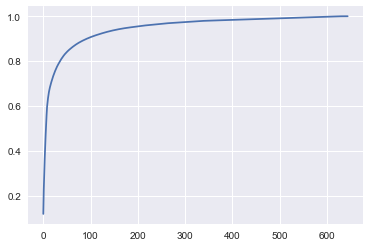

In [87]:
plt.plot(cumsum)
plt.show()

In [8]:
import sys
reload(sys)
sys.setdefaultencoding('utf-8')

In [9]:
X.shape

(4715, 647)

In [ ]:
a